In [1]:
import pandas as pd
import numpy as np

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 16, 4

In [2]:
from AJ_ML_Library import models_classification

In [3]:
train = pd.read_csv('data/train_modified_11.csv')
test = pd.read_csv('data/test_modified_11.csv')

In [4]:
train.shape, test.shape

((7381, 236), (11171, 235))

In [5]:
train.columns

Index([u'event_count', u'event_type 10', u'event_type 11', u'event_type 13',
       u'event_type 14', u'event_type 15', u'event_type 18', u'event_type 2',
       u'event_type 20', u'event_type 21',
       ...
       u'resource_type 9', u'severity_type 1', u'severity_type 2',
       u'severity_type 3', u'severity_type 4', u'severity_type 5',
       u'resource_type 8and2', u'resource_type_change',
       u'location_previous_same', u'segment'],
      dtype='object', length=236)

In [6]:
train['fault_severity'].value_counts()

0    4784
1    1871
2     726
Name: fault_severity, dtype: int64

In [7]:
target = 'fault_severity'
IDcol = 'id'
output_colnames = ['predict_0','predict_1','predict_2']

## XGBOOST
### (Models with New XGBoost Definition)

In [8]:
models_classification = reload(models_classification)

In [9]:
predictors = [x for x in train.columns if x not in [target, 'location2',IDcol]]

### Get the num_boost_round for 0.1 learning rate

Model based on few count features:

In [10]:
# for i in range(2,10)

Will train until cv error hasn't decreased in 50 rounds.
Stopping. Best iteration:
[140] cv-mean:0.4917162	cv-std:0.00929189919015


{'reg_alpha': 0, 'colsample_bytree': 0.65, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.1, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 141, 'subsample': 1, 'reg_lambda': 1, 'seed': 0, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0}


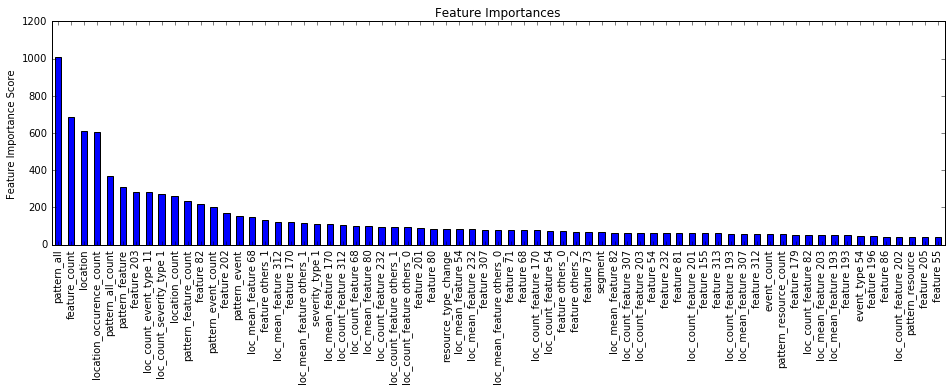


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4429   244  111
1                359  1444   68
2                 41    32  653
Note: rows - actual; col - predicted
Train (Accuracy) : 88.416%
Train (log_loss) : 0.321843
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000


In [10]:
predictors = [x for x in predictors if not x.startswith('occurence')]
# predictors = [x for x in predictors if x!='location_occurence_count']
xgb1 = models_classification.XGBoost_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
xgb1.set_parameters({
        'learning_rate':0.1,
        'n_estimators':1000,
        'max_depth':6,
        'min_child_weight':1,
        'gamma':0,
        'subsample':1,
        'colsample_bytree':0.65,
        'objective': 'multi:softprob',
        'num_class':3,
        'eval_metric':['mlogloss'],
        'missing':-1,
        'nthread':4,
        'scale_pos_weight':1
    })
xgb1.modelfit(useTrainCV=True,performCV=False,show_progress=False,printTopN=70,early_stopping_rounds=50)

In [ ]:
xgb1.get_feature_importance()

Grid search on max_depth, min_child_weight

In [11]:
xgb2 = models_classification.XGBoost_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
xgb2.set_parameters({
         'learning_rate':0.1,
        'n_estimators':140,
        'max_depth':6,
        'min_child_weight':1,
        'gamma':0,
        'subsample':1,
        'colsample_bytree':0.65,
        'objective': 'multi:softprob',
        'num_class':3,
        'eval_metric':['mlogloss'],
        'missing':-1,
        'nthread':4,
        'scale_pos_weight':1,
    })
param_test1 = {
    'max_depth':range(4,8),
    'min_child_weight':range(0,3)
}
xgb2.GridSearch(param_test1,n_jobs=4,iid=False,cv=5)

Grid Search Results:
    max_depth  min_child_weight    meanCV     stdCV
0           4                 0 -0.499458  0.008900
1           4                 1 -0.499581  0.008307
2           4                 2 -0.499366  0.008392
3           5                 0 -0.490914  0.007468
4           5                 1 -0.489346  0.009252
5           5                 2 -0.491511  0.008171
6           6                 0 -0.489895  0.009501
7           6                 1 -0.489084  0.008806
8           6                 2 -0.489798  0.009132
9           7                 0 -0.491588  0.008146
10          7                 1 -0.490181  0.009666
11          7                 2 -0.490899  0.010000

Best Parameters:  {'max_depth': 6, 'min_child_weight': 1}

Best Score:  -0.4890841427


In [12]:
# xgb3 = models_classification.XGBoost_Class(train, test, target, predictors, cv_folds=5, 
#                                            scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
# xgb3.set_parameters({
#          'learning_rate':0.1,
#         'n_estimators':133,
#         'max_depth':6,
#         'min_child_weight':1,
#         'gamma':0,
#         'subsample':1,
#         'colsample_bytree':0.65,
#         'objective': 'multi:softprob',
#         'num_class':3,
#         'eval_metric':['mlogloss'],
#         'missing':-1,
#         'nthread':4,
#         'scale_pos_weight':1,
#         'seed':27
#     })
# param_test2 = {
#     'min_child_weight':range(2,5),
# }
# xgb3.GridSearch(param_test2,n_jobs=4,iid=False,cv=5)

In [ ]:
# xgb4 = models_classification.XGBoost_Class(train, test, target, predictors, cv_folds=5, 
#                                            scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
# xgb4.set_parameters({
#         'learning_rate':0.1,
#         'n_estimators':153,
#         'max_depth':6,
#         'min_child_weight':1,
#         'gamma':0,
#         'subsample':0.7,
#         'colsample_bytree':0.7,
#         'objective': 'multi:softprob',
#         'num_class':3,
#         'eval_metric':['mlogloss'],
#         'missing':-1,
#         'nthread':4,
#         'scale_pos_weight':1
#     })
# param_test3 = {
#     'min_child_weight':range(1,4)
# }
# xgb4.GridSearch(param_test3,n_jobs=4,iid=False,cv=5)

In [ ]:
# xgb4.set_parameters({
#         'learning_rate':0.1,
#         'n_estimators':153,
#         'max_depth':6,
#         'min_child_weight':1,
#         'gamma':0,
#         'subsample':0.7,
#         'colsample_bytree':0.7,
#         'objective': 'multi:softprob',
#         'num_class':3,
#         'eval_metric':['mlogloss'],
#         'missing':-1,
#         'nthread':4,
#         'scale_pos_weight':1
#     })
# xgb4.modelfit(useTrainCV=True,performCV=False)

In [13]:
xgb5 = models_classification.XGBoost_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
xgb5.set_parameters({
         'learning_rate':0.1,
        'n_estimators':140,
        'max_depth':6,
        'min_child_weight':1,
        'gamma':0,
        'subsample':1,
        'colsample_bytree':0.65,
        'objective': 'multi:softprob',
        'num_class':3,
        'eval_metric':['mlogloss'],
        'missing':-1,
        'nthread':4,
        'scale_pos_weight':1,
        'seed':27
    })
param_test4 = {
    'gamma':[x/100.0 for x in range(0,21,5)]
}
xgb5.GridSearch(param_test4,n_jobs=4,iid=False,cv=5)

Grid Search Results:
   gamma    meanCV     stdCV
0   0.00 -0.487997  0.009473
1   0.05 -0.486987  0.010164
2   0.10 -0.488202  0.010364
3   0.15 -0.488711  0.010040
4   0.20 -0.489136  0.010088

Best Parameters:  {'gamma': 0.05}

Best Score:  -0.486986962304


This is poorer than 0 so we'll keep it to 0
check for subsample next

In [14]:
xgb6 = models_classification.XGBoost_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
xgb6.set_parameters({
        'learning_rate':0.1,
        'n_estimators':140,
        'max_depth':6,
        'min_child_weight':1,
        'gamma':0.05,
        'subsample':1,
        'colsample_bytree':0.65,
        'objective': 'multi:softprob',
        'num_class':3,
        'eval_metric':['mlogloss'],
        'missing':-1,
        'nthread':4,
        'scale_pos_weight':1,
        'seed':27
    })
param_test5 = {
    'subsample':[x/10.0 for x in range(5,11)],
    'colsample_bytree':[x/10.0 for x in range(5,9)]
}
xgb6.GridSearch(param_test5,n_jobs=4,iid=False,cv=5)

Grid Search Results:
    subsample  colsample_bytree    meanCV     stdCV
0         0.5               0.5 -0.492461  0.009101
1         0.6               0.5 -0.489050  0.005520
2         0.7               0.5 -0.487855  0.006653
3         0.8               0.5 -0.485086  0.010412
4         0.9               0.5 -0.485298  0.008487
5         1.0               0.5 -0.487227  0.010651
6         0.5               0.6 -0.493440  0.006676
7         0.6               0.6 -0.490176  0.005639
8         0.7               0.6 -0.486894  0.009511
9         0.8               0.6 -0.485611  0.010346
10        0.9               0.6 -0.485218  0.010348
11        1.0               0.6 -0.487595  0.009884
12        0.5               0.7 -0.493628  0.007581
13        0.6               0.7 -0.489238  0.007519
14        0.7               0.7 -0.489459  0.008632
15        0.8               0.7 -0.487322  0.008751
16        0.9               0.7 -0.488004  0.009812
17        1.0               0.7 -0.488663  

In [15]:
xgb7 = models_classification.XGBoost_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
xgb7.set_parameters({
        'learning_rate':0.1,
        'n_estimators':140,
        'max_depth':6,
        'min_child_weight':1,
        'gamma':0.05,
        'subsample':1,
        'colsample_bytree':0.65,
        'objective': 'multi:softprob',
        'num_class':3,
        'eval_metric':['mlogloss'],
        'missing':-1,
        'nthread':4,
        'scale_pos_weight':1,
        'seed':27
    })
param_test6 = {
    'subsample':[0.75,0.85],
    'colsample_bytree':[0.45,0.55]
}
xgb7.GridSearch(param_test6,n_jobs=4,iid=False,cv=5)

Grid Search Results:
   subsample  colsample_bytree    meanCV     stdCV
0       0.75              0.45 -0.485497  0.008887
1       0.85              0.45 -0.485137  0.008711
2       0.75              0.55 -0.485622  0.010034
3       0.85              0.55 -0.484812  0.009077

Best Parameters:  {'subsample': 0.85, 'colsample_bytree': 0.55}

Best Score:  -0.484811843316


In [ ]:
# xgb8 = models_classification.XGBoost_Class(train, test, target, predictors, cv_folds=5, 
#                                            scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
# xgb8.set_parameters({
#         'learning_rate':0.1,
#         'n_estimators':131,
#         'max_depth':6,
#         'min_child_weight':1,
#         'gamma':0,
#         'subsample':0.95,
#         'colsample_bytree':0.5,
#         'objective': 'multi:softprob',
#         'num_class':3,
#         'eval_metric':['mlogloss'],
#         'missing':-1,
#         'nthread':4,
#         'scale_pos_weight':1,
#         'seed':27
#     })
# param_test7 = {
#     'scale_pos_weight':range(1,11,3),
# }
# xgb8.GridSearch(param_test7,n_jobs=4,iid=False,cv=5)

In [ ]:
# xgb9 = models_classification.XGBoost_Class(train, test, target, predictors, cv_folds=5, 
#                                            scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
# xgb9.set_parameters({
#         'learning_rate':0.01,
#         'n_estimators':2000,
#         'max_depth':6,
#         'min_child_weight':2,
#         'gamma':0,
#         'subsample':0.85,
#         'colsample_bytree':0.45,
#         'objective': 'multi:softprob',
#         'num_class':3,
#         'eval_metric':['mlogloss'],
#         'missing':-1,
#         'nthread':4,
#         'scale_pos_weight':1,
#     })
# xgb9.modelfit(useTrainCV=True,performCV=False,show_progress=False,printTopN=50,early_stopping_rounds=100)

In [16]:
from sklearn.cross_validation import StratifiedShuffleSplit

In [17]:
sss = StratifiedShuffleSplit(train['fault_severity'],10,test_size=0.5)

In [18]:
for train_split, test_split in sss:
    split1 = train_split
    split2 = test_split
train_h1 = train.iloc[split1]
train_h2 = train.iloc[split2]

In [19]:
print train_h1['fault_severity'].value_counts()
print train_h2['fault_severity'].value_counts()

0    2392
1     935
2     363
Name: fault_severity, dtype: int64
0    2392
1     936
2     363
Name: fault_severity, dtype: int64


Will train until cv error hasn't decreased in 100 rounds.
Stopping. Best iteration:
[173] cv-mean:0.5107528	cv-std:0.0258569075908


{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.05, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 174, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 0, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


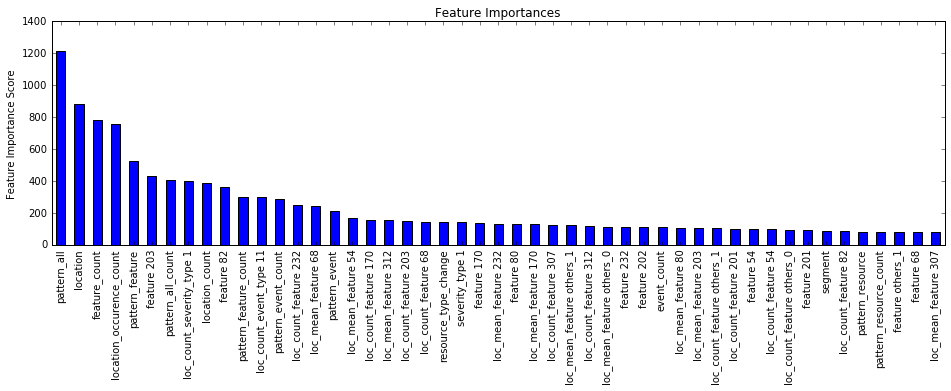


Model Report
Confusion Matrix:
col_0              0    1    2
fault_severity                
0               2248  113   31
1                166  742   27
2                 23   10  330
Note: rows - actual; col - predicted
Train (Accuracy) : 89.973%
Train (log_loss) : 0.301992
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000


In [21]:
xgb10a = models_classification.XGBoost_Class(train_h1, train_h2, target, predictors, cv_folds=5, 
                                           scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
xgb10a.set_parameters({
       'learning_rate':0.05,
        'n_estimators':1000,
        'max_depth':6,
        'min_child_weight':1,
        'gamma':0.05,
        'subsample':0.85,
        'colsample_bytree':0.55,
        'objective': 'multi:softprob',
        'num_class':3,
        'eval_metric':['mlogloss'],
        'missing':-1,
        'nthread':4,
        'scale_pos_weight':1,
    })
xgb10a.modelfit(useTrainCV=True,performCV=False,show_progress=False,printTopN=50,early_stopping_rounds=100)

Will train until cv error hasn't decreased in 100 rounds.
Stopping. Best iteration:
[138] cv-mean:0.531696	cv-std:0.0131101095648


{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.05, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 139, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 0, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


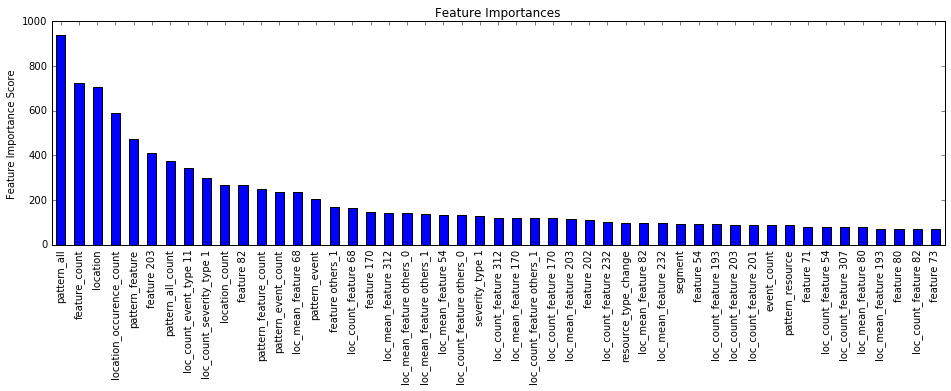


Model Report
Confusion Matrix:
col_0              0    1    2
fault_severity                
0               2245  112   35
1                197  713   26
2                 25   17  321
Note: rows - actual; col - predicted
Train (Accuracy) : 88.838%
Train (log_loss) : 0.337454
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000


In [22]:
xgb10b = models_classification.XGBoost_Class(train_h2, train_h1, target, predictors, cv_folds=5, 
                                           scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
xgb10b.set_parameters({
       'learning_rate':0.05,
        'n_estimators':1000,
        'max_depth':6,
        'min_child_weight':1,
        'gamma':0.05,
        'subsample':0.85,
        'colsample_bytree':0.55,
        'objective': 'multi:softprob',
        'num_class':3,
        'eval_metric':['mlogloss'],
        'missing':-1,
        'nthread':4,
        'scale_pos_weight':1,
    })
xgb10b.modelfit(useTrainCV=True,performCV=False,show_progress=False,printTopN=50,early_stopping_rounds=100)

In [23]:
train_h2['stack_pred_0'] = 0
train_h2['stack_pred_1'] = 0
train_h2['stack_pred_2'] = 0
train_h2[['stack_pred_0','stack_pred_1','stack_pred_2']] = xgb10a.get_test_predictions(getprob=True)

train_h1['stack_pred_0'] = 0
train_h1['stack_pred_1'] = 0
train_h1['stack_pred_2'] = 0
train_h1[['stack_pred_0','stack_pred_1','stack_pred_2']] = xgb10b.get_test_predictions(getprob=True)

/Users/aarshay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/aarshay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/aarshay/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

In [24]:
train_h2[['stack_pred_0','stack_pred_1','stack_pred_2']].head()

,stack_pred_0,stack_pred_1,stack_pred_2
1718,0.708476,0.284030,0.007494
6346,0.992782,0.006452,0.000766
1196,0.632956,0.353572,0.013471
3793,0.961924,0.034426,0.003650
1314,0.136833,0.231254,0.631913


In [25]:
train2 = pd.concat([train_h1,train_h2],ignore_index=True)

Will train until cv error hasn't decreased in 100 rounds.
Stopping. Best iteration:
[299] cv-mean:0.4874266	cv-std:0.0102293488473


{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.05, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 300, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 0, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


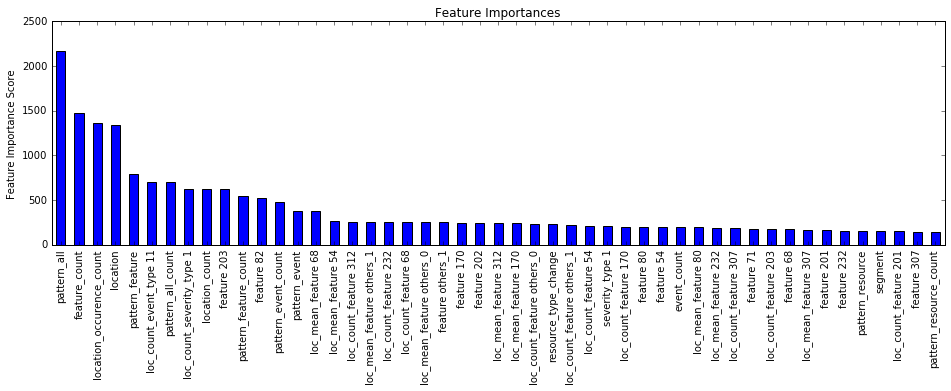


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4469   233   82
1                323  1494   54
2                 30    27  669
Note: rows - actual; col - predicted
Train (Accuracy) : 89.852%
Train (log_loss) : 0.298508
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000


In [26]:
xgb10c = models_classification.XGBoost_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
xgb10c.set_parameters({
        'learning_rate':0.05,
        'n_estimators':1000,
        'max_depth':6,
        'min_child_weight':1,
        'gamma':0.05,
        'subsample':0.85,
        'colsample_bytree':0.55,
        'objective': 'multi:softprob',
        'num_class':3,
        'eval_metric':['mlogloss'],
        'missing':-1,
        'nthread':4,
        'scale_pos_weight':1,
    })
xgb10c.modelfit(useTrainCV=True,performCV=False,show_progress=False,printTopN=50,early_stopping_rounds=100)

In [27]:
test2 = pd.DataFrame(test,copy=True)
test2['stack_pred_0'] = 0
test2['stack_pred_1'] = 0
test2['stack_pred_2'] = 0
test2[['stack_pred_0','stack_pred_1','stack_pred_2']] = xgb10c.get_test_predictions(getprob=True)

In [35]:
# predictors = [x for x in train2.columns if x not in [target, 'location2',IDcol]]
# xgb11 = models_classification.XGBoost_Class(train2, test2, target, predictors, cv_folds=5, 
#                                            scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
# xgb11.set_parameters({
#       'learning_rate':0.05,
#         'n_estimators':1000,
#         'max_depth':6,
#         'min_child_weight':2,
#         'gamma':0.1,
#         'subsample':0.9,
#         'colsample_bytree':0.5,
#         'objective': 'multi:softprob',
#         'num_class':3,
#         'eval_metric':['mlogloss'],
#         'missing':-1,
#         'nthread':4,
#         'scale_pos_weight':1,
#     })
# xgb11.modelfit(useTrainCV=True,performCV=False,show_progress=False,printTopN=50,early_stopping_rounds=100)

In [ ]:
# stack_col = ['stack_pred_0','stack_pred_1','stack_pred_2']
# train3 = pd.DataFrame(train2,copy=True)
# test3 = pd.DataFrame(test2,copy=True)
# train3['stack_pred'] = train3[stack_col].apply(lambda x: np.argmax(x.values),axis=1)
# test3['stack_pred'] = test3[stack_col].apply(lambda x: np.argmax(x.values),axis=1)

In [ ]:
# train3[stack_col+['stack_pred']].head()

In [ ]:
# train3.drop(stack_col,axis=1,inplace=True)
# test3.drop(stack_col,axis=1,inplace=True)

In [ ]:
# predictors = [x for x in train3.columns if x not in [target, 'location2',IDcol]]
# xgb12 = models_classification.XGBoost_Class(train3, test3, target, predictors, cv_folds=5, 
#                                            scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
# xgb12.set_parameters({
#         'learning_rate':0.1,
#         'n_estimators':1000,
#         'max_depth':6,
#         'min_child_weight':2,
#         'gamma':0,
#         'subsample':0.9,
#         'colsample_bytree':0.5,
#         'objective': 'multi:softprob',
#         'num_class':3,
#         'eval_metric':['mlogloss'],
#         'missing':-1,
#         'nthread':4,
#         'scale_pos_weight':1,
#     })
# xgb12.modelfit(useTrainCV=True,performCV=False,show_progress=False,printTopN=50,early_stopping_rounds=100)

In [ ]:
# xgb12.submission_proba(IDcol=[IDcol], proba_colnames=output_colnames, filename='submissions/xgb12_mod9.csv')
#Score:xx

In [38]:
# xgb12.export_model([IDcol])

Will train until cv error hasn't decreased in 100 rounds.
Stopping. Best iteration:
[745] cv-mean:0.4867164	cv-std:0.0185314985428


{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 746, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 0, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


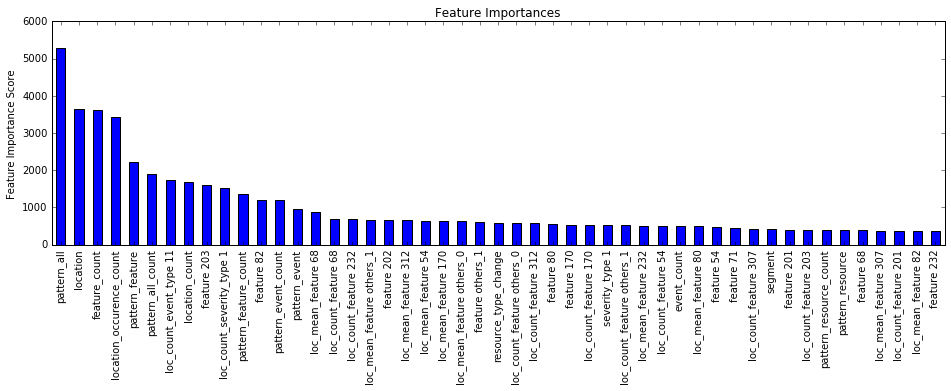


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4485   218   81
1                307  1511   53
2                 30    24  672
Note: rows - actual; col - predicted
Train (Accuracy) : 90.340%
Train (log_loss) : 0.297251
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000


In [29]:
xgb12b = models_classification.XGBoost_Class(train2, test2, target, predictors, cv_folds=5, 
                                               scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
xgb12b.set_parameters({
    'learning_rate':0.02,
        'n_estimators':1000,
        'max_depth':6,
        'min_child_weight':1,
        'gamma':0.05,
        'subsample':0.85,
        'colsample_bytree':0.55,
        'objective': 'multi:softprob',
        'num_class':3,
        'eval_metric':['mlogloss'],
        'missing':-1,
        'nthread':4,
        'scale_pos_weight':1,
    })
xgb12b.modelfit(useTrainCV=True,performCV=False,show_progress=False,printTopN=50,early_stopping_rounds=100)

{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 745, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 55, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


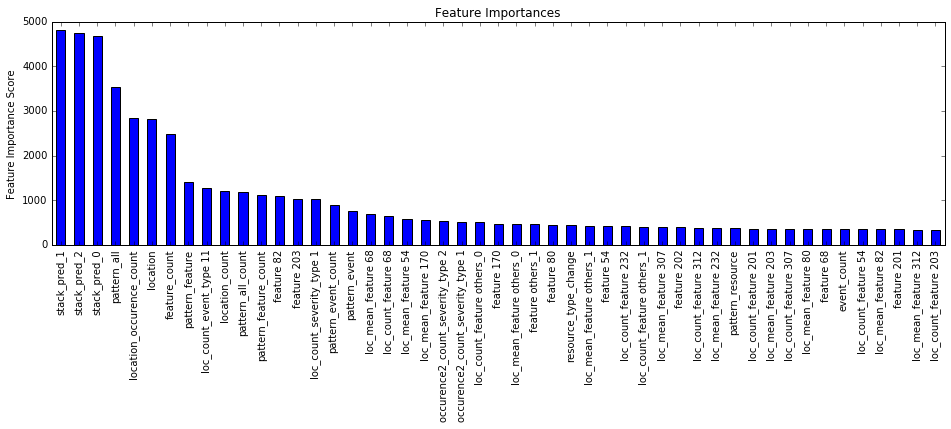


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4551   188   45
1                292  1537   42
2                 19    14  693
Note: rows - actual; col - predicted
Train (Accuracy) : 91.871%
Train (log_loss) : 0.269323
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 745, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 1055, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


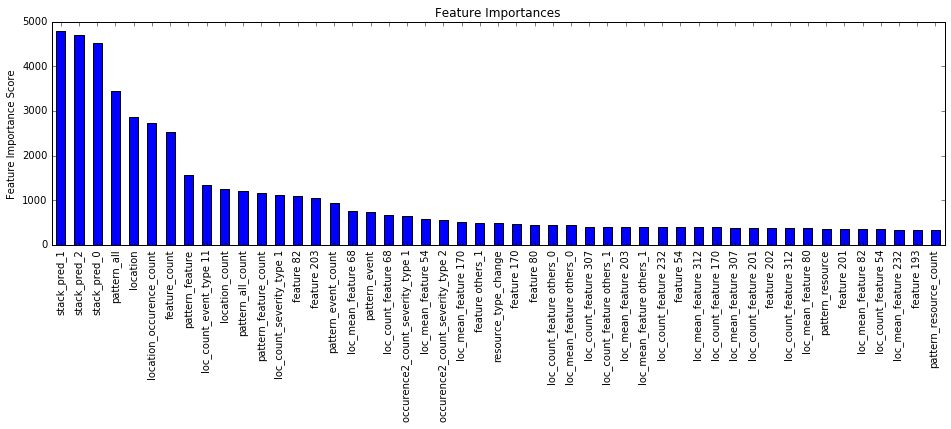


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4531   197   56
1                289  1541   41
2                 21    18  687
Note: rows - actual; col - predicted
Train (Accuracy) : 91.573%
Train (log_loss) : 0.268262
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 745, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 2055, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


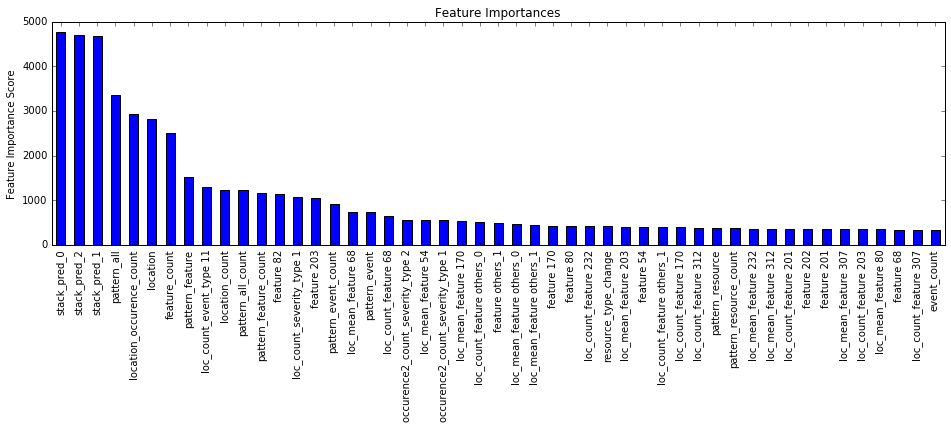


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4542   193   49
1                287  1543   41
2                 19    17  690
Note: rows - actual; col - predicted
Train (Accuracy) : 91.790%
Train (log_loss) : 0.268588
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 745, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 3055, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


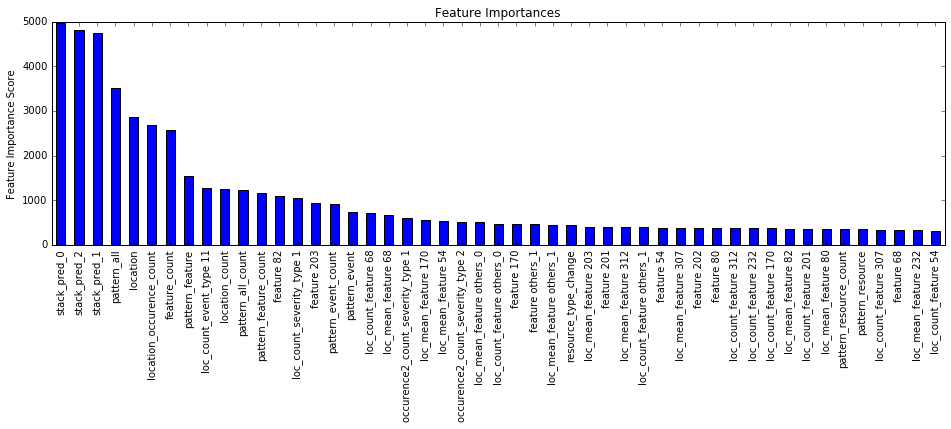


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4542   190   52
1                284  1545   42
2                 19    16  691
Note: rows - actual; col - predicted
Train (Accuracy) : 91.830%
Train (log_loss) : 0.267752
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 745, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 4055, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


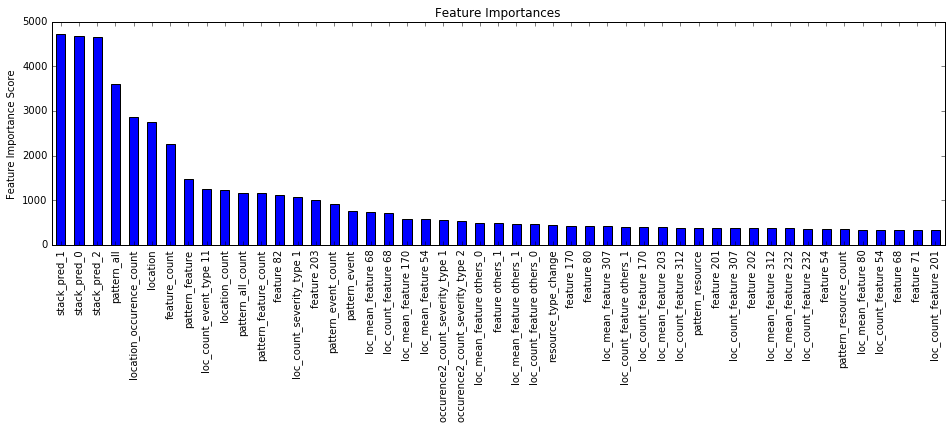


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4530   204   50
1                292  1536   43
2                 20    21  685
Note: rows - actual; col - predicted
Train (Accuracy) : 91.465%
Train (log_loss) : 0.270507
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 745, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 5055, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


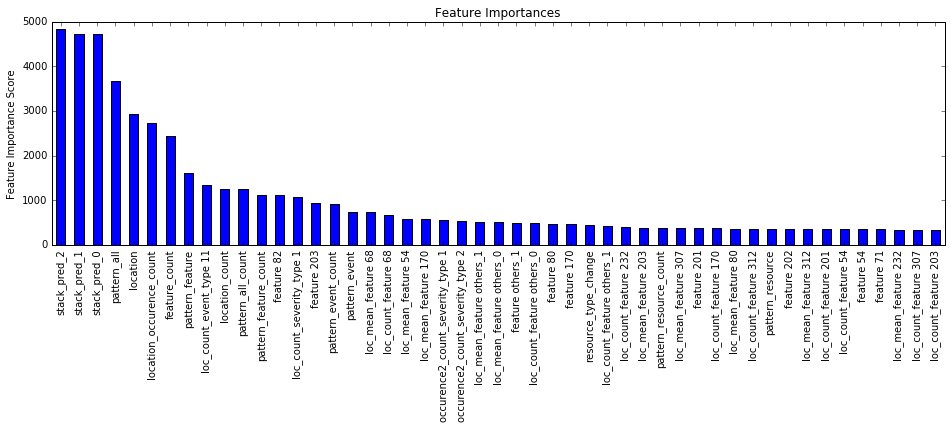


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4545   194   45
1                291  1539   41
2                 19    17  690
Note: rows - actual; col - predicted
Train (Accuracy) : 91.776%
Train (log_loss) : 0.268024
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 745, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 6055, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


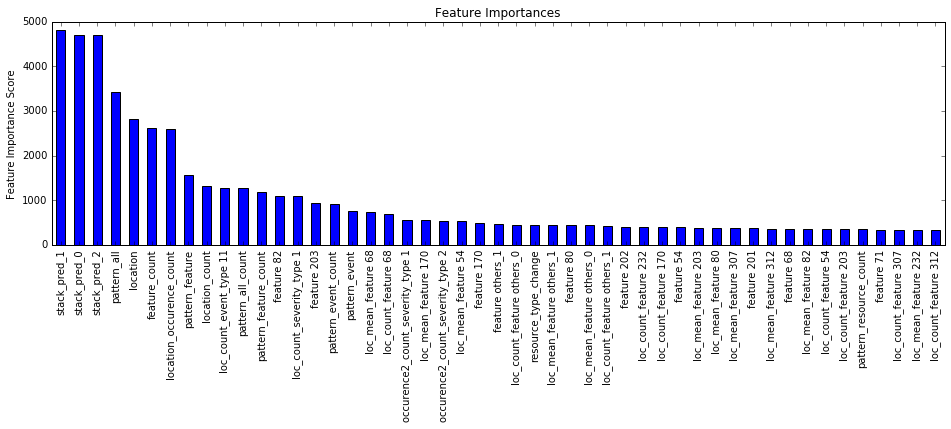


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4533   203   48
1                289  1544   38
2                 20    17  689
Note: rows - actual; col - predicted
Train (Accuracy) : 91.668%
Train (log_loss) : 0.269686
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 745, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 7055, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


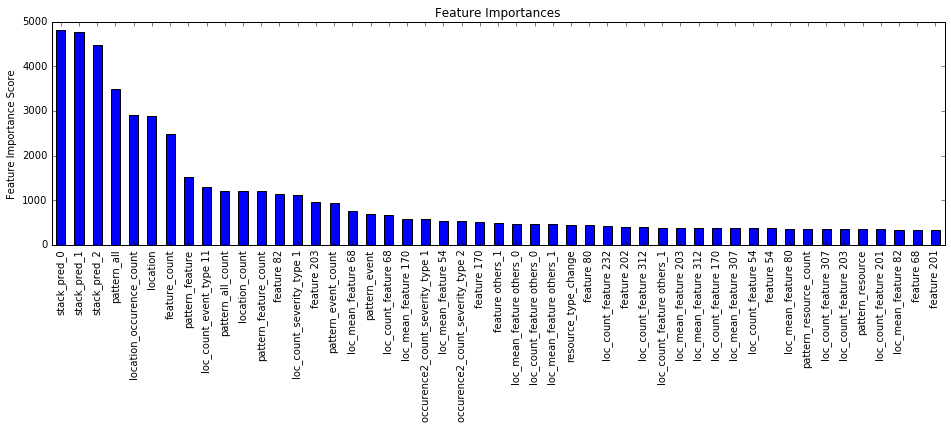


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4537   197   50
1                282  1544   45
2                 18    16  692
Note: rows - actual; col - predicted
Train (Accuracy) : 91.763%
Train (log_loss) : 0.268477
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 745, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 8055, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


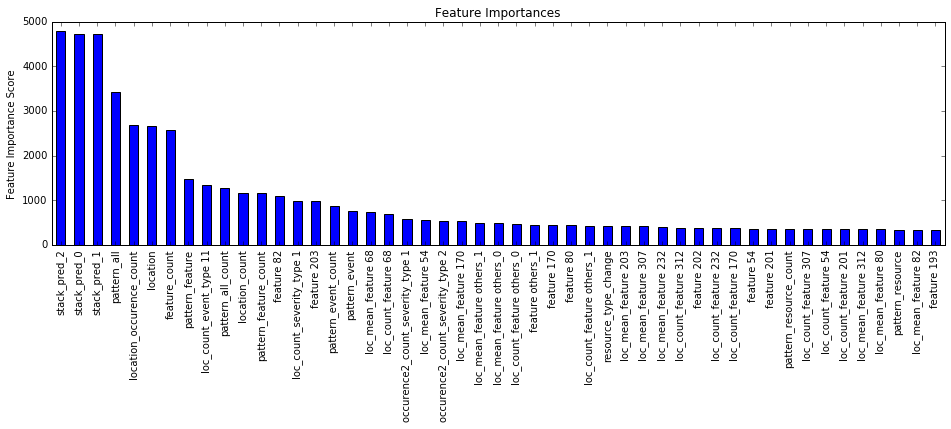


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4538   195   51
1                303  1525   43
2                 19    17  690
Note: rows - actual; col - predicted
Train (Accuracy) : 91.492%
Train (log_loss) : 0.270664
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 745, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 9055, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


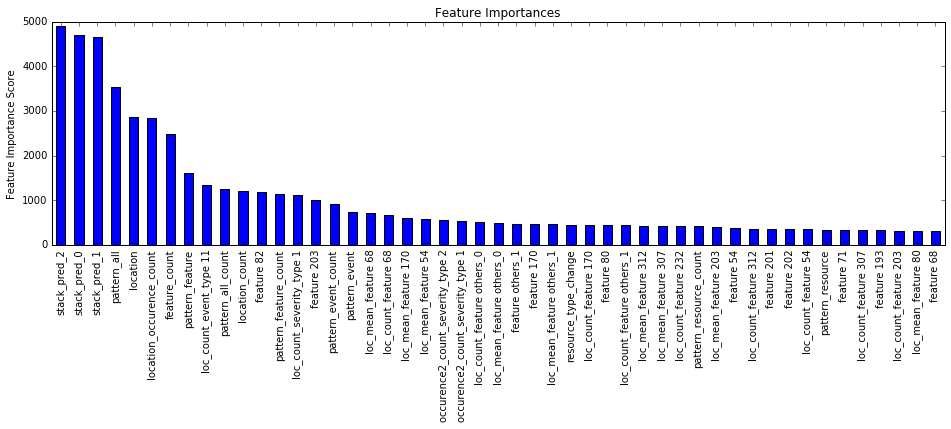


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4540   194   50
1                286  1545   40
2                 19    13  694
Note: rows - actual; col - predicted
Train (Accuracy) : 91.844%
Train (log_loss) : 0.267691
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000


In [30]:
predictors = [x for x in train2.columns if x not in [target, 'location2',IDcol]]

for s in range(55,10000,1000):
    xgb13 = models_classification.XGBoost_Class(train2, test2, target, predictors, cv_folds=5, 
                                               scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
    xgb13.set_parameters({
            'learning_rate':0.02,
        'n_estimators':745,
        'max_depth':6,
        'min_child_weight':1,
        'gamma':0.05,
        'subsample':0.85,
        'colsample_bytree':0.55,
        'objective': 'multi:softprob',
        'num_class':3,
        'eval_metric':['mlogloss'],
        'missing':-1,
        'nthread':4,
        'scale_pos_weight':1,
            'seed':s
        })
    xgb13.modelfit(useTrainCV=False,performCV=False,show_progress=False,printTopN=50,early_stopping_rounds=50)
    fn = 'submissions/xgb13_mod11_seed%d.csv'%s
    xgb13.submission_proba(IDcol=[IDcol], proba_colnames=output_colnames, filename=fn)

In [31]:
def combine_models_multi(files, newfile):
    f1 = pd.read_csv(files[0])
    f = pd.DataFrame(f1,copy=True)
    nf = len(files)
    for i in range(1,nf):
        f1 = pd.read_csv(files[i])
        f['predict_0'] += f1['predict_0']
        f['predict_1'] += f1['predict_1']
        f['predict_2'] += f1['predict_2']
    f['predict_0'] /= nf
    f['predict_1'] /= nf
    f['predict_2'] /= nf
    print round(sum(f[['predict_0','predict_1','predict_2']].sum()),0)==f.shape[0]
    f.to_csv(newfile,index=False)

In [32]:
model_comb = ['submissions/xgb13_mod11_seed%d.csv'%s for s in range(55,10000,1000)]
model_comb

['submissions/xgb13_mod11_seed55.csv',
 'submissions/xgb13_mod11_seed1055.csv',
 'submissions/xgb13_mod11_seed2055.csv',
 'submissions/xgb13_mod11_seed3055.csv',
 'submissions/xgb13_mod11_seed4055.csv',
 'submissions/xgb13_mod11_seed5055.csv',
 'submissions/xgb13_mod11_seed6055.csv',
 'submissions/xgb13_mod11_seed7055.csv',
 'submissions/xgb13_mod11_seed8055.csv',
 'submissions/xgb13_mod11_seed9055.csv']

In [33]:
combine_models_multi(model_comb, 'submissions/xgb13_mod11_seedcombo.csv')
#Score: 0.50293

True


## Create Ensemble:

### 1. Random Forest

In [34]:
# models_classification = reload(models_classification)

Model being built with the following parameters:
{'warm_start': False, 'oob_score': True, 'n_jobs': 4, 'verbose': 0, 'max_leaf_nodes': 64, 'bootstrap': True, 'min_samples_leaf': 10, 'n_estimators': 500, 'min_samples_split': 30, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


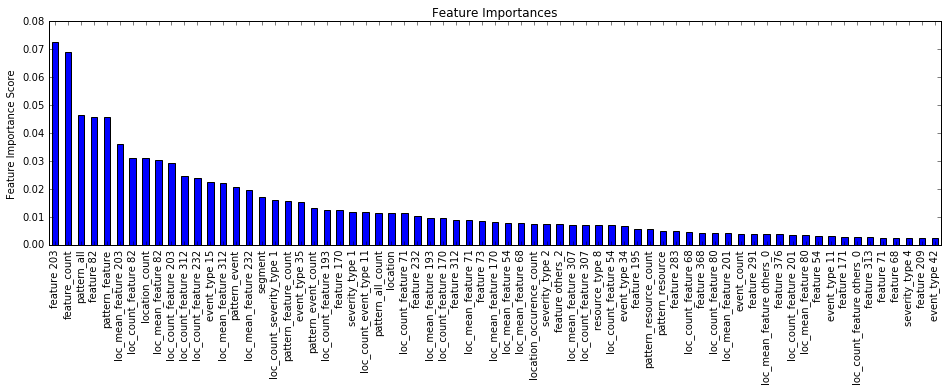

OOB Score : 0.719686

Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               3482   871  431
1                263  1335  273
2                  9    52  665
Note: rows - actual; col - predicted
Train (Accuracy) : 74.272%
Train (log_loss) : 0.626959
AUC : nan%
CV Score (Specified Metric) : Mean - -0.657021 | Std - 0.014858


In [35]:
predictors = [x for x in train.columns if x not in [target, 'location2',IDcol]]
predictors = [x for x in predictors if not x.startswith('occurence')]
# predictors = [x for x in predictors if x!='location_occurence_count']
rf1 = models_classification.Random_Forest_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
rf1.set_parameters({
        'criterion':'gini',
        'n_estimators':500,
        'max_leaf_nodes':2**6,
        'min_samples_split':30,
        'min_samples_leaf':10,
        'max_features':'sqrt',
        'oob_score':True,
        'n_jobs':4,
        'class_weight':'balanced_subsample'
    })
rf1.modelfit(performCV=True,printTopN=70)

In [36]:
rf2 = models_classification.Random_Forest_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
rf2.set_parameters({
        'criterion':'gini',
        'n_estimators':500,
        'max_leaf_nodes':2**6,
        'min_samples_split':30,
        'min_samples_leaf':10,
        'max_features':'sqrt',
        'oob_score':True,
        'n_jobs':4,
        'class_weight':'balanced_subsample',
        'random_state':78
    })
param_test1 = {
    'max_leaf_nodes':[2**x for x in range(4,9)],
    'min_samples_split':range(10,100,20)
}
rf2.GridSearch(param_test1,n_jobs=4,iid=False,cv=5)

Grid Search Results:
    min_samples_split  max_leaf_nodes    meanCV     stdCV
0                  10              16 -0.745670  0.014709
1                  30              16 -0.745423  0.014922
2                  50              16 -0.745464  0.014889
3                  70              16 -0.745418  0.015133
4                  90              16 -0.746126  0.015100
5                  10              32 -0.698311  0.014533
6                  30              32 -0.698085  0.014705
7                  50              32 -0.698418  0.015421
8                  70              32 -0.698341  0.015185
9                  90              32 -0.699312  0.015152
10                 10              64 -0.657477  0.014541
11                 30              64 -0.657052  0.013859
12                 50              64 -0.657796  0.014625
13                 70              64 -0.660256  0.014980
14                 90              64 -0.663083  0.014799
15                 10             128 -0.626758  0.

In [37]:
rf3 = models_classification.Random_Forest_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
rf3.set_parameters({
        'criterion':'gini',
        'n_estimators':500,
        'max_leaf_nodes':2**6,
        'min_samples_split':10,
        'max_features':'sqrt',
        'oob_score':True,
        'n_jobs':4,
        'class_weight':'balanced_subsample',
        'random_state':78
    })
param_test1 = {
    'max_leaf_nodes':[2**x for x in range(9,12)],
    'min_samples_split':[5,10]
}
rf3.GridSearch(param_test1,n_jobs=4,iid=False,cv=5)

Grid Search Results:
   min_samples_split  max_leaf_nodes    meanCV     stdCV
0                  5             512 -0.529405  0.009585
1                 10             512 -0.531034  0.010393
2                  5            1024 -0.514399  0.014442
3                 10            1024 -0.527524  0.010892
4                  5            2048 -0.514399  0.014442
5                 10            2048 -0.527524  0.010892

Best Parameters:  {'min_samples_split': 5, 'max_leaf_nodes': 1024}

Best Score:  -0.514399477963


### 2. Extra Trees Classifier

Model being built with the following parameters:
{'warm_start': False, 'oob_score': False, 'n_jobs': 4, 'verbose': 0, 'max_leaf_nodes': 1024, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


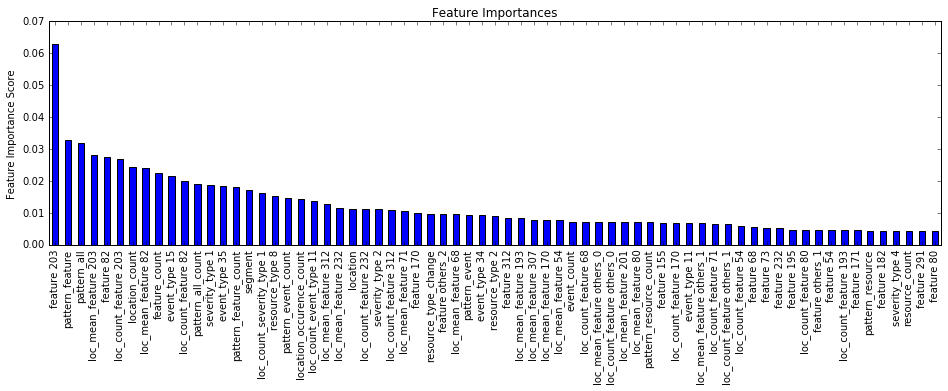


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4214   371  199
1                138  1636   97
2                  0     0  726
Note: rows - actual; col - predicted
Train (Accuracy) : 89.094%
Train (log_loss) : 0.347652
AUC : nan%
CV Score (Specified Metric) : Mean - -0.557338 | Std - 0.014646


In [38]:
predictors = [x for x in train.columns if x not in [target, 'location2',IDcol]]
predictors = [x for x in predictors if not x.startswith('occurence')]
# predictors = [x for x in predictors if x!='location_occurence_count']
etc1 = models_classification.ExtraTrees_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
etc1.set_parameters({
        'criterion':'gini',
        'n_estimators':500,
        'max_leaf_nodes':2**10,
        'min_samples_split':5,
        'max_features':'sqrt',
        'n_jobs':4,
        'class_weight':'balanced_subsample'
    })
etc1.modelfit(performCV=True,printTopN=70)

In [39]:
etc2 = models_classification.ExtraTrees_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
etc2.set_parameters({
        'criterion':'gini',
        'n_estimators':500,
        'max_leaf_nodes':2**6,
        'min_samples_split':30,
        'max_features':'sqrt',
        'n_jobs':4,
        'class_weight':'balanced_subsample',
        'random_state':78
    })
param_test1 = {
    'max_leaf_nodes':[2**x for x in range(8,12)],
    'min_samples_split':[1,5,10,15]
}
etc2.GridSearch(param_test1,n_jobs=4,iid=False,cv=5)

Grid Search Results:
    min_samples_split  max_leaf_nodes    meanCV     stdCV
0                   1             256 -0.644856  0.018143
1                   5             256 -0.640625  0.017685
2                  10             256 -0.637644  0.017925
3                  15             256 -0.635847  0.018270
4                   1             512 -0.603289  0.015632
5                   5             512 -0.598603  0.016166
6                  10             512 -0.595751  0.016156
7                  15             512 -0.595060  0.017532
8                   1            1024 -0.561012  0.014340
9                   5            1024 -0.557987  0.015500
10                 10            1024 -0.561363  0.016683
11                 15            1024 -0.579131  0.022670
12                  1            2048 -0.532722  0.015153
13                  5            2048 -0.540929  0.019505
14                 10            2048 -0.562864  0.021689
15                 15            2048 -0.579131  0.

In [41]:
etc2b = models_classification.ExtraTrees_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
etc2b.set_parameters({
        'criterion':'gini',
        'n_estimators':500,
        'max_leaf_nodes':2**6,
        'min_samples_split':1,
        'max_features':'sqrt',
        'n_jobs':4,
        'class_weight':'balanced_subsample',
        'random_state':78
    })
param_test1 = {
    'max_leaf_nodes':[2**x for x in range(12,15)],
}
etc2b.GridSearch(param_test1,n_jobs=4,iid=False,cv=5)

Grid Search Results:
   max_leaf_nodes    meanCV     stdCV
0            4096 -0.555678  0.024575
1            8192 -0.555678  0.024575
2           16384 -0.555678  0.024575

Best Parameters:  {'max_leaf_nodes': 4096}

Best Score:  -0.555677842894


## Create dataframe with OOF predictions of each:

In [42]:
# train3 = pd.DataFrame(train2, copy=True)
# test3 = pd.DataFrame(test2, copy=True)
colrename = {'stack_pred_0':'stack_pred_0_xgb',
            'stack_pred_1':'stack_pred_1_xgb',
            'stack_pred_2':'stack_pred_2_xgb'}
# train3 = train3.rename(colrename)
test2 = test2.rename(columns= colrename)
train_h1 = train_h1.rename(columns=colrename)
train_h2 = train_h2.rename(columns=colrename)

Model being built with the following parameters:
{'warm_start': False, 'oob_score': True, 'n_jobs': 4, 'verbose': 0, 'max_leaf_nodes': 1024, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


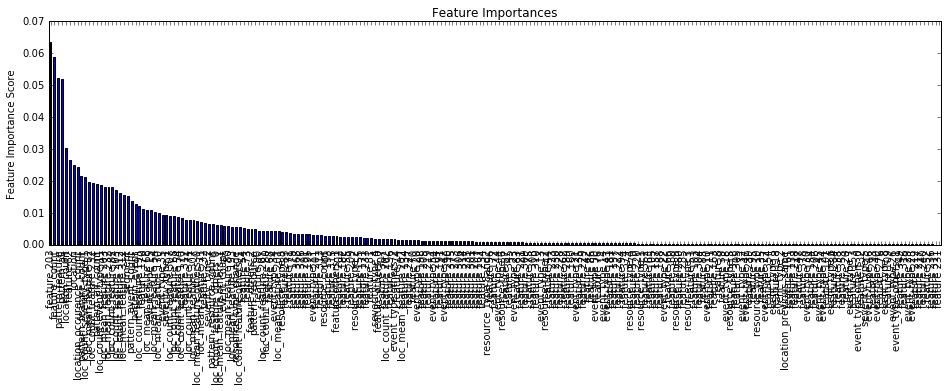

OOB Score : 0.768835

Model Report
Confusion Matrix:
col_0              0    1    2
fault_severity                
0               2287   55   50
1                 10  910   15
2                  0    0  363
Note: rows - actual; col - predicted
Train (Accuracy) : 96.477%
Train (log_loss) : 0.233468
AUC : nan%
CV Score (Specified Metric) : Mean - -0.526502 | Std - 0.012707
Model being built with the following parameters:
{'warm_start': False, 'oob_score': True, 'n_jobs': 4, 'verbose': 0, 'max_leaf_nodes': 1024, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


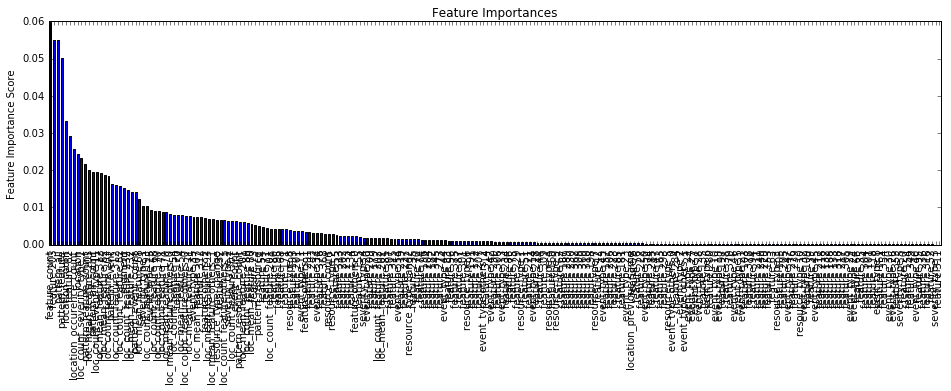

OOB Score : 0.760499

Model Report
Confusion Matrix:
col_0              0    1    2
fault_severity                
0               2294   43   55
1                 19  897   20
2                  0    0  363
Note: rows - actual; col - predicted
Train (Accuracy) : 96.288%
Train (log_loss) : 0.242078
AUC : nan%
CV Score (Specified Metric) : Mean - -0.558675 | Std - 0.020454
Model being built with the following parameters:
{'warm_start': False, 'oob_score': True, 'n_jobs': 4, 'verbose': 0, 'max_leaf_nodes': 1024, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


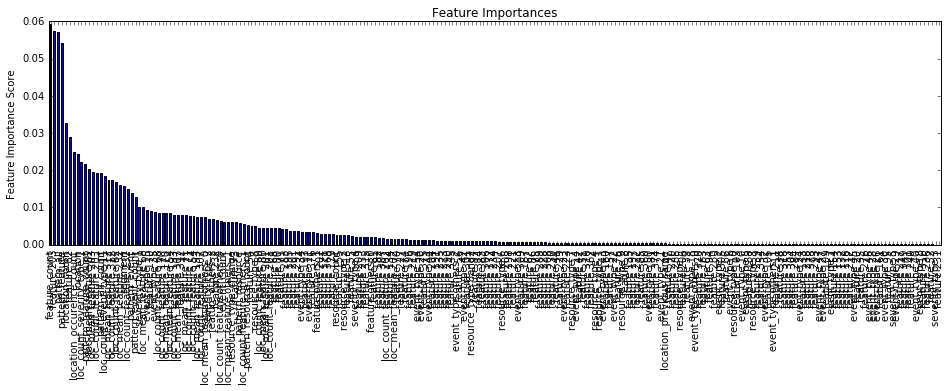

OOB Score : 0.779163

Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4536   125  123
1                 45  1783   43
2                  0     0  726
Note: rows - actual; col - predicted
Train (Accuracy) : 95.448%
Train (log_loss) : 0.239533
AUC : nan%
CV Score (Specified Metric) : Mean - -0.514839 | Std - 0.014680


In [43]:
rf4a = models_classification.Random_Forest_Class(train_h1, train_h2, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
rf4a.set_parameters({
        'criterion':'gini',
        'n_estimators':500,
        'max_leaf_nodes':2**10,
        'min_samples_split':5,
        'max_features':'sqrt',
        'oob_score':True,
        'n_jobs':4,
        'class_weight':'balanced_subsample',
    })
rf4a.modelfit(performCV=True)

rf4b = models_classification.Random_Forest_Class(train_h2, train_h1, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
rf4b.set_parameters({
        'criterion':'gini',
        'n_estimators':500,
        'max_leaf_nodes':2**10,
        'min_samples_split':5,
        'max_features':'sqrt',
        'oob_score':True,
        'n_jobs':4,
        'class_weight':'balanced_subsample',
    })
rf4b.modelfit(performCV=True)

rf4c = models_classification.Random_Forest_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
rf4c.set_parameters({
        'criterion':'gini',
        'n_estimators':500,
        'max_leaf_nodes':2**10,
        'min_samples_split':5,
        'max_features':'sqrt',
        'oob_score':True,
        'n_jobs':4,
        'class_weight':'balanced_subsample',
    })
rf4c.modelfit(performCV=True)

In [44]:
prefix = 'rfgini'
colnames = ['stack_pred_%d_%s'%(i,prefix) for i in range(0,3)]
train_h2[colnames[0]] = 0
train_h2[colnames[1]] = 0
train_h2[colnames[2]] = 0
train_h2[colnames] = rf4a.get_test_predictions(getprob=True)

train_h1[colnames[0]] = 0
train_h1[colnames[1]] = 0
train_h1[colnames[2]] = 0
train_h1[colnames] = rf4b.get_test_predictions(getprob=True)

test2[colnames[0]] = 0
test2[colnames[1]] = 0
test2[colnames[2]] = 0
test2[colnames] = rf4c.get_test_predictions(getprob=True)

Model being built with the following parameters:
{'warm_start': False, 'oob_score': True, 'n_jobs': 4, 'verbose': 0, 'max_leaf_nodes': 1024, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'criterion': 'entropy', 'random_state': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


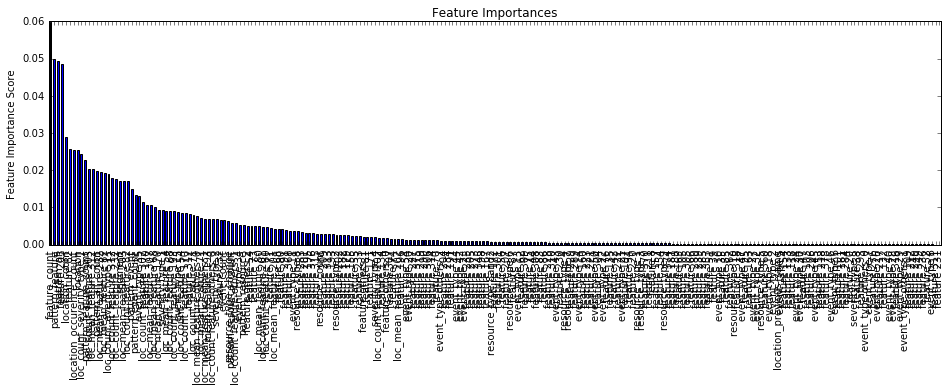

OOB Score : 0.769919

Model Report
Confusion Matrix:
col_0              0    1    2
fault_severity                
0               2298   44   50
1                 10  908   17
2                  0    0  363
Note: rows - actual; col - predicted
Train (Accuracy) : 96.721%
Train (log_loss) : 0.228986
AUC : nan%
CV Score (Specified Metric) : Mean - -0.525858 | Std - 0.012283
Model being built with the following parameters:
{'warm_start': False, 'oob_score': True, 'n_jobs': 4, 'verbose': 0, 'max_leaf_nodes': 1024, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'criterion': 'entropy', 'random_state': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


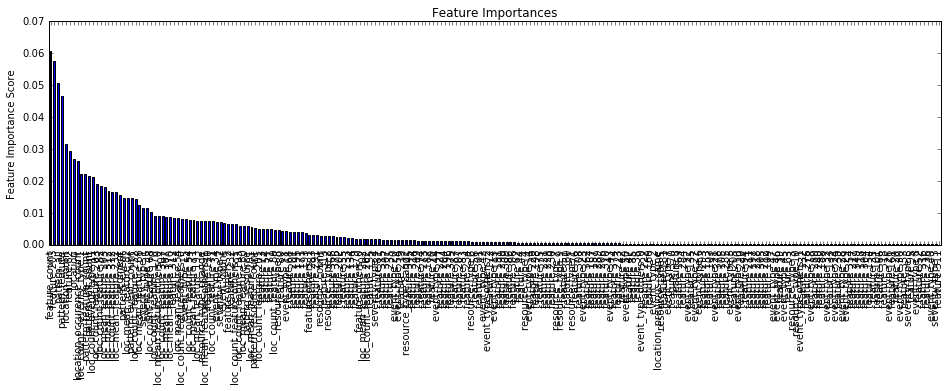

OOB Score : 0.761311

Model Report
Confusion Matrix:
col_0              0    1    2
fault_severity                
0               2305   36   51
1                 13  903   20
2                  0    0  363
Note: rows - actual; col - predicted
Train (Accuracy) : 96.749%
Train (log_loss) : 0.237020
AUC : nan%
CV Score (Specified Metric) : Mean - -0.549791 | Std - 0.008210
Model being built with the following parameters:
{'warm_start': False, 'oob_score': True, 'n_jobs': 4, 'verbose': 0, 'max_leaf_nodes': 1024, 'bootstrap': True, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 5, 'min_weight_fraction_leaf': 0.0, 'criterion': 'entropy', 'random_state': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


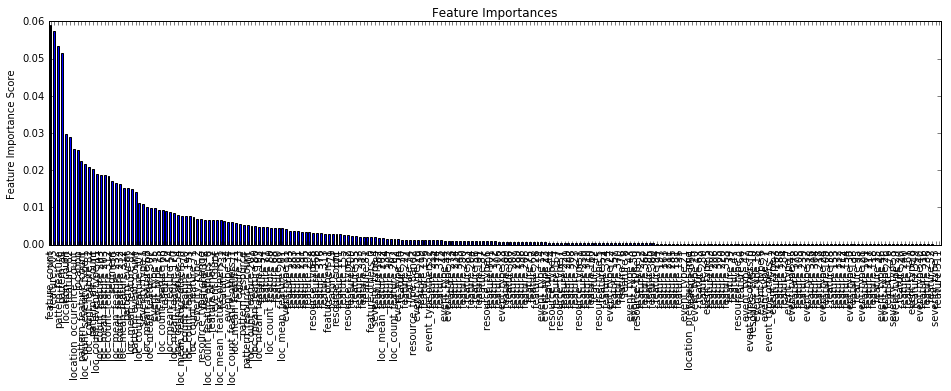

OOB Score : 0.775640

Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4548   115  121
1                 43  1784   44
2                  0     0  726
Note: rows - actual; col - predicted
Train (Accuracy) : 95.624%
Train (log_loss) : 0.237661
AUC : nan%
CV Score (Specified Metric) : Mean - -0.514602 | Std - 0.014977


In [45]:
rf5a = models_classification.Random_Forest_Class(train_h1, train_h2, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
rf5a.set_parameters({
        'criterion':'entropy',
        'n_estimators':500,
        'max_leaf_nodes':2**10,
        'min_samples_split':5,
        'max_features':'sqrt',
        'oob_score':True,
        'n_jobs':4,
        'class_weight':'balanced_subsample',
    })
rf5a.modelfit(performCV=True)

rf5b = models_classification.Random_Forest_Class(train_h2, train_h1, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
rf5b.set_parameters({
        'criterion':'entropy',
        'n_estimators':500,
        'max_leaf_nodes':2**10,
        'min_samples_split':5,
        'max_features':'sqrt',
        'oob_score':True,
        'n_jobs':4,
        'class_weight':'balanced_subsample',
    })
rf5b.modelfit(performCV=True)

rf5c = models_classification.Random_Forest_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
rf5c.set_parameters({
        'criterion':'entropy',
        'n_estimators':500,
        'max_leaf_nodes':2**10,
        'min_samples_split':5,
        'max_features':'sqrt',
        'oob_score':True,
        'n_jobs':4,
        'class_weight':'balanced_subsample',
    })
rf5c.modelfit(performCV=True)

In [46]:
prefix = 'rfentropy'
colnames = ['stack_pred_%d_%s'%(i,prefix) for i in range(0,3)]
train_h2[colnames[0]] = 0
train_h2[colnames[1]] = 0
train_h2[colnames[2]] = 0
train_h2[colnames] = rf5a.get_test_predictions(getprob=True)

train_h1[colnames[0]] = 0
train_h1[colnames[1]] = 0
train_h1[colnames[2]] = 0
train_h1[colnames] = rf5b.get_test_predictions(getprob=True)

test2[colnames[0]] = 0
test2[colnames[1]] = 0
test2[colnames[2]] = 0
test2[colnames] = rf5c.get_test_predictions(getprob=True)

Model being built with the following parameters:
{'warm_start': False, 'oob_score': False, 'n_jobs': 4, 'verbose': 0, 'max_leaf_nodes': 2048, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 1, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


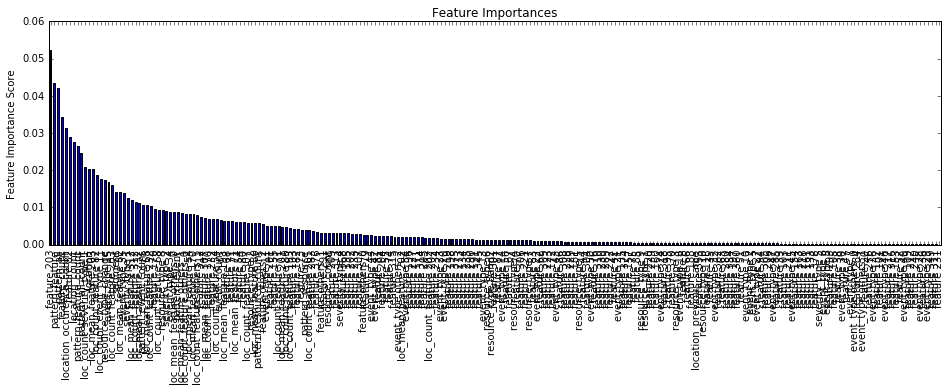


Model Report
Confusion Matrix:
col_0              0    1    2
fault_severity                
0               2392    0    0
1                  0  935    0
2                  0    0  363
Note: rows - actual; col - predicted
Train (Accuracy) : 100.000%
Train (log_loss) : 0.000000
AUC : nan%
CV Score (Specified Metric) : Mean - -0.568325 | Std - 0.015655
Model being built with the following parameters:
{'warm_start': False, 'oob_score': False, 'n_jobs': 4, 'verbose': 0, 'max_leaf_nodes': 2048, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 1, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


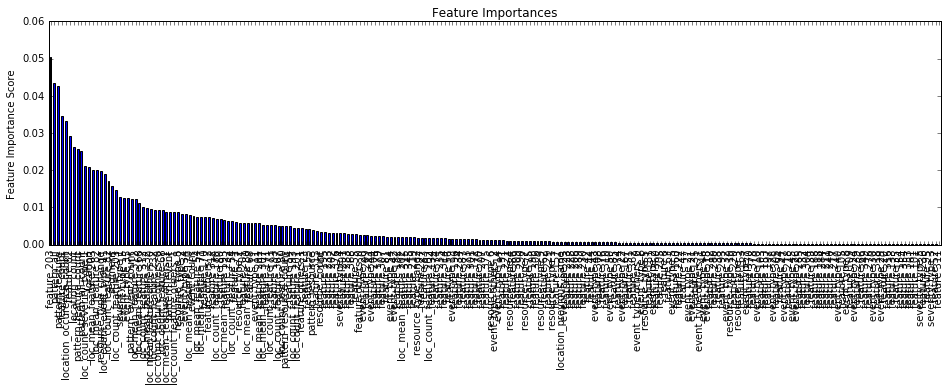


Model Report
Confusion Matrix:
col_0              0    1    2
fault_severity                
0               2392    0    0
1                  0  936    0
2                  0    0  363
Note: rows - actual; col - predicted
Train (Accuracy) : 100.000%
Train (log_loss) : 0.000000
AUC : nan%
CV Score (Specified Metric) : Mean - -0.626334 | Std - 0.024486
Model being built with the following parameters:
{'warm_start': False, 'oob_score': False, 'n_jobs': 4, 'verbose': 0, 'max_leaf_nodes': 2048, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 1, 'min_weight_fraction_leaf': 0.0, 'criterion': 'gini', 'random_state': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


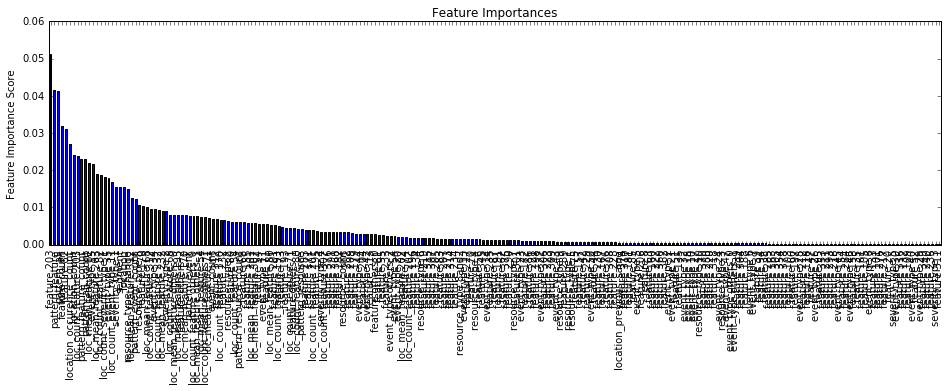


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4656    82   46
1                 28  1838    5
2                  0     0  726
Note: rows - actual; col - predicted
Train (Accuracy) : 97.819%
Train (log_loss) : 0.159089
AUC : nan%
CV Score (Specified Metric) : Mean - -0.532559 | Std - 0.015854


In [47]:
etc3a = models_classification.ExtraTrees_Class(train_h1, train_h2, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
etc3a.set_parameters({
        'criterion':'gini',
        'n_estimators':500,
        'max_leaf_nodes':2**11,
        'min_samples_split':1,
        'max_features':'sqrt',
        'n_jobs':4,
        'class_weight':'balanced_subsample',
    })
etc3a.modelfit(performCV=True)

etc3b = models_classification.ExtraTrees_Class(train_h2, train_h1, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
etc3b.set_parameters({
        'criterion':'gini',
        'n_estimators':500,
        'max_leaf_nodes':2**11,
        'min_samples_split':1,
        'max_features':'sqrt',
        'n_jobs':4,
        'class_weight':'balanced_subsample',
    })
etc3b.modelfit(performCV=True)

etc3c = models_classification.ExtraTrees_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
etc3c.set_parameters({
        'criterion':'gini',
        'n_estimators':500,
        'max_leaf_nodes':2**11,
        'min_samples_split':1,
        'max_features':'sqrt',
        'n_jobs':4,
        'class_weight':'balanced_subsample',
    })
etc3c.modelfit(performCV=True)

prefix = 'etcgini'
colnames = ['stack_pred_%d_%s'%(i,prefix) for i in range(0,3)]
train_h2[colnames[0]] = 0
train_h2[colnames[1]] = 0
train_h2[colnames[2]] = 0
train_h2[colnames] = etc3a.get_test_predictions(getprob=True)

train_h1[colnames[0]] = 0
train_h1[colnames[1]] = 0
train_h1[colnames[2]] = 0
train_h1[colnames] = etc3b.get_test_predictions(getprob=True)

test2[colnames[0]] = 0
test2[colnames[1]] = 0
test2[colnames[2]] = 0
test2[colnames] = etc3c.get_test_predictions(getprob=True)

Model being built with the following parameters:
{'warm_start': False, 'oob_score': False, 'n_jobs': 4, 'verbose': 0, 'max_leaf_nodes': 2048, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 1, 'min_weight_fraction_leaf': 0.0, 'criterion': 'entropy', 'random_state': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


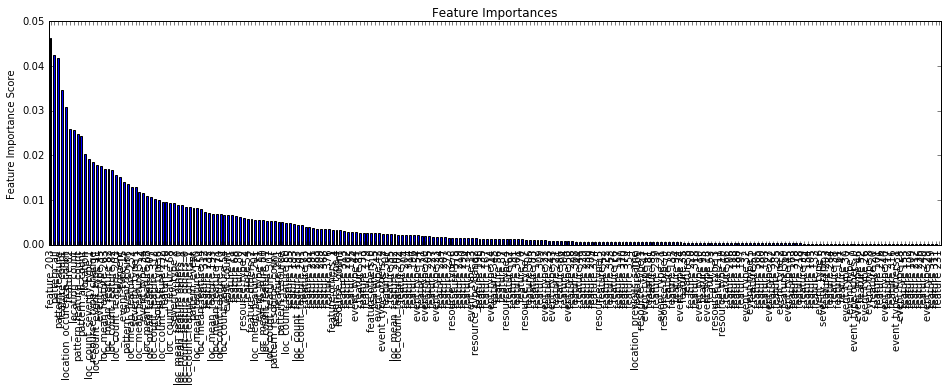


Model Report
Confusion Matrix:
col_0              0    1    2
fault_severity                
0               2392    0    0
1                  0  935    0
2                  0    0  363
Note: rows - actual; col - predicted
Train (Accuracy) : 100.000%
Train (log_loss) : 0.000000
AUC : nan%
CV Score (Specified Metric) : Mean - -0.575502 | Std - 0.021641
Model being built with the following parameters:
{'warm_start': False, 'oob_score': False, 'n_jobs': 4, 'verbose': 0, 'max_leaf_nodes': 2048, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 1, 'min_weight_fraction_leaf': 0.0, 'criterion': 'entropy', 'random_state': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


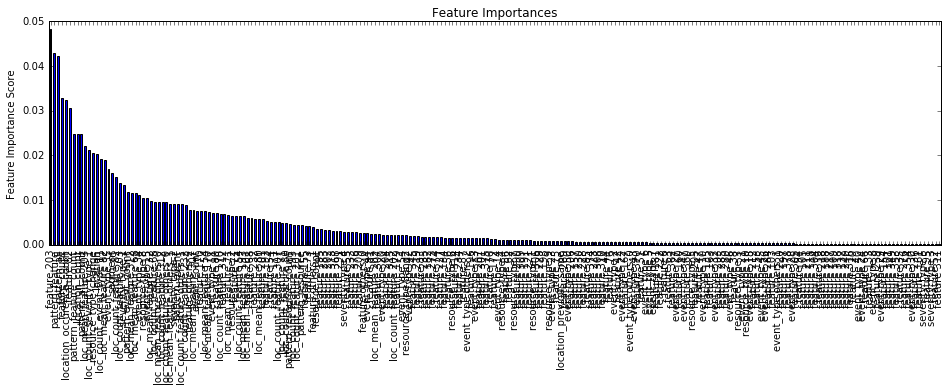


Model Report
Confusion Matrix:
col_0              0    1    2
fault_severity                
0               2392    0    0
1                  0  936    0
2                  0    0  363
Note: rows - actual; col - predicted
Train (Accuracy) : 100.000%
Train (log_loss) : 0.000000
AUC : nan%
CV Score (Specified Metric) : Mean - -0.617570 | Std - 0.022369
Model being built with the following parameters:
{'warm_start': False, 'oob_score': False, 'n_jobs': 4, 'verbose': 0, 'max_leaf_nodes': 2048, 'bootstrap': False, 'min_samples_leaf': 1, 'n_estimators': 500, 'min_samples_split': 1, 'min_weight_fraction_leaf': 0.0, 'criterion': 'entropy', 'random_state': None, 'max_features': 'sqrt', 'max_depth': None, 'class_weight': 'balanced_subsample'}


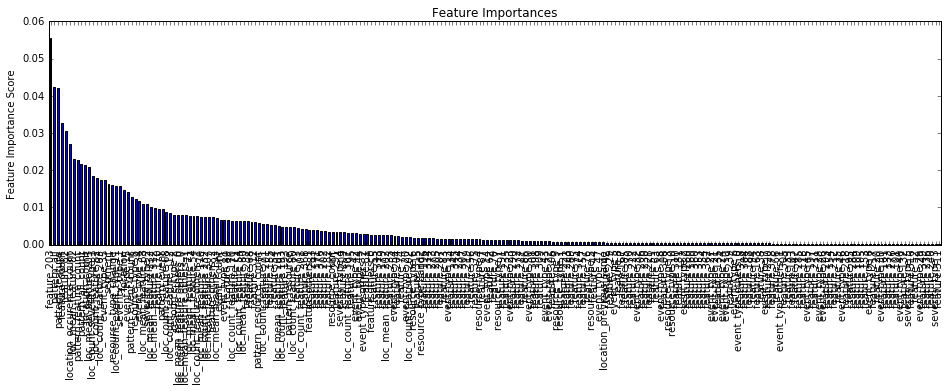


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4671   107    6
1                 49  1822    0
2                  0     0  726
Note: rows - actual; col - predicted
Train (Accuracy) : 97.805%
Train (log_loss) : 0.169903
AUC : nan%
CV Score (Specified Metric) : Mean - -0.536463 | Std - 0.020842


In [48]:
etc4a = models_classification.ExtraTrees_Class(train_h1, train_h2, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
etc4a.set_parameters({
        'criterion':'entropy',
        'n_estimators':500,
        'max_leaf_nodes':2**11,
        'min_samples_split':1,
        'max_features':'sqrt',
        'n_jobs':4,
        'class_weight':'balanced_subsample',
    })
etc4a.modelfit(performCV=True)

etc4b = models_classification.ExtraTrees_Class(train_h2, train_h1, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
etc4b.set_parameters({
        'criterion':'entropy',
        'n_estimators':500,
        'max_leaf_nodes':2**11,
        'min_samples_split':1,
        'max_features':'sqrt',
        'n_jobs':4,
        'class_weight':'balanced_subsample',
    })
etc4b.modelfit(performCV=True)

etc4c = models_classification.ExtraTrees_Class(train, test, target, predictors, cv_folds=5, 
                                           scoring_metric='log_loss')
etc4c.set_parameters({
        'criterion':'entropy',
        'n_estimators':500,
        'max_leaf_nodes':2**11,
        'min_samples_split':1,
        'max_features':'sqrt',
        'n_jobs':4,
        'class_weight':'balanced_subsample',
    })
etc4c.modelfit(performCV=True)

prefix = 'etcentropy'
colnames = ['stack_pred_%d_%s'%(i,prefix) for i in range(0,3)]
train_h2[colnames[0]] = 0
train_h2[colnames[1]] = 0
train_h2[colnames[2]] = 0
train_h2[colnames] = etc4a.get_test_predictions(getprob=True)

train_h1[colnames[0]] = 0
train_h1[colnames[1]] = 0
train_h1[colnames[2]] = 0
train_h1[colnames] = etc4b.get_test_predictions(getprob=True)

test2[colnames[0]] = 0
test2[colnames[1]] = 0
test2[colnames[2]] = 0
test2[colnames] = etc4c.get_test_predictions(getprob=True)

In [49]:
train2 = pd.concat([train_h1,train_h2],ignore_index=True)

## Create logistic regression with prediction outputs:

In [50]:
models_classification = reload(models_classification)

In [51]:
pred_logistic = [x for x in train_h1.columns if x.startswith('stack_pred_')]

In [52]:
# logreg1 = models_classification.Logistic_Regression(train2, test2, target, pred_logistic, scoring_metric= 'log_loss')
# logreg1.set_parameters({
#         'solver':'lbfgs',
#         'multi_class':'multinomial'
#     })
# x = logreg1.modelfit()

## Use outcomes as features in xgboost:

Will train until cv error hasn't decreased in 100 rounds.
Stopping. Best iteration:
[390] cv-mean:0.492926	cv-std:0.0180824360527


{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 391, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 9055, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


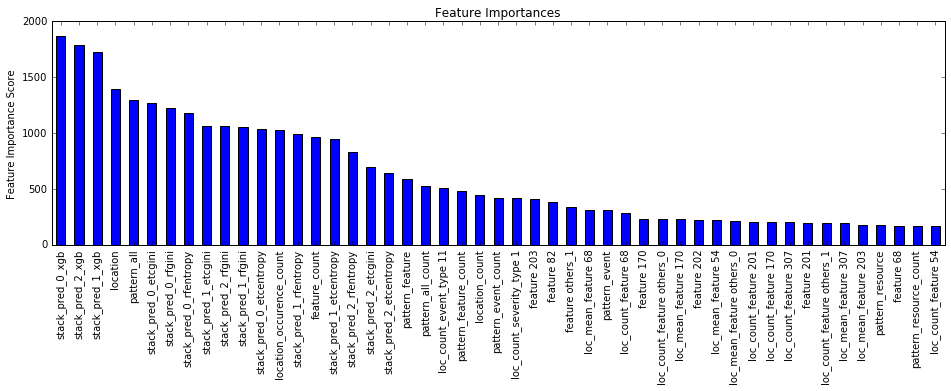


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4450   247   87
1                387  1410   74
2                 36    26  664
Note: rows - actual; col - predicted
Train (Accuracy) : 88.389%
Train (log_loss) : 0.315878
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000


In [54]:
predictors = [x for x in train2.columns if x not in [target, 'location2',IDcol]]
predictors = [x for x in predictors if not x.startswith('occurence')]

xgb14 = models_classification.XGBoost_Class(train2, test2, target, predictors, cv_folds=5, 
                                           scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
xgb14.set_parameters({
        'learning_rate':0.02,
    'n_estimators':1500,
    'max_depth':6,
    'min_child_weight':1,
    'gamma':0.05,
    'subsample':0.85,
    'colsample_bytree':0.55,
    'objective': 'multi:softprob',
    'num_class':3,
    'eval_metric':['mlogloss'],
    'missing':-1,
    'nthread':4,
    'scale_pos_weight':1,
        'seed':s
    })
xgb14.modelfit(useTrainCV=True,performCV=False,show_progress=False,printTopN=50,early_stopping_rounds=100)

In [55]:
xgb14.submission_proba(IDcol=[IDcol], proba_colnames=output_colnames, filename='submissions/xgb14_mod11.csv')
# Score: 0.49984

In [56]:
# xgb14.get_feature_importance().to_csv('feature_importance.csv')

{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 390, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 100, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


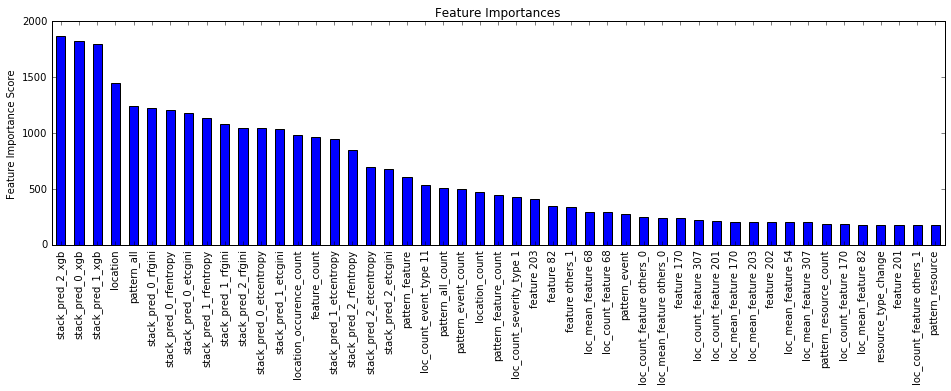


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4431   248  105
1                382  1420   69
2                 32    27  667
Note: rows - actual; col - predicted
Train (Accuracy) : 88.308%
Train (log_loss) : 0.314670
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 390, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 1100, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


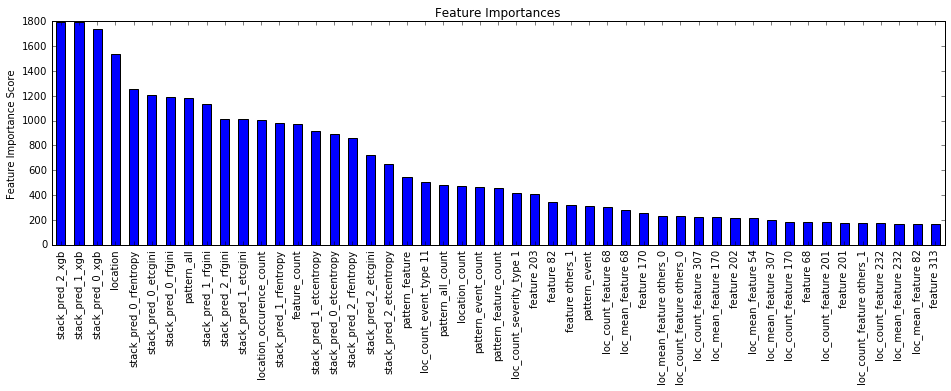


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4422   263   99
1                391  1408   72
2                 35    23  668
Note: rows - actual; col - predicted
Train (Accuracy) : 88.037%
Train (log_loss) : 0.317243
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 390, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 2100, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


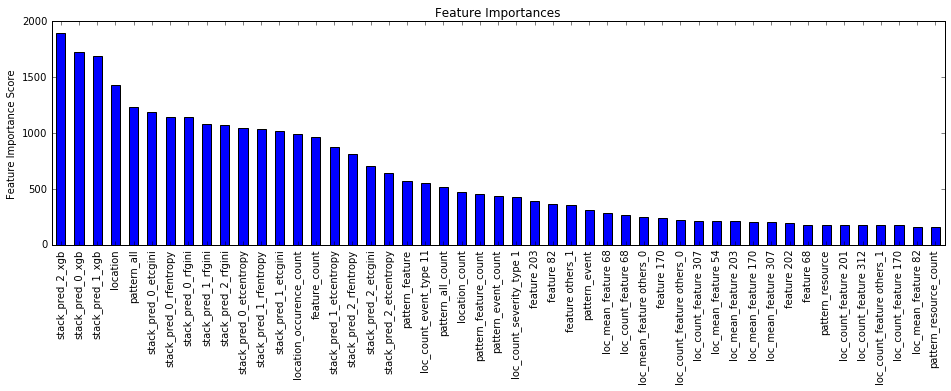


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4422   256  106
1                399  1397   75
2                 37    28  661
Note: rows - actual; col - predicted
Train (Accuracy) : 87.793%
Train (log_loss) : 0.317959
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 390, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 3100, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


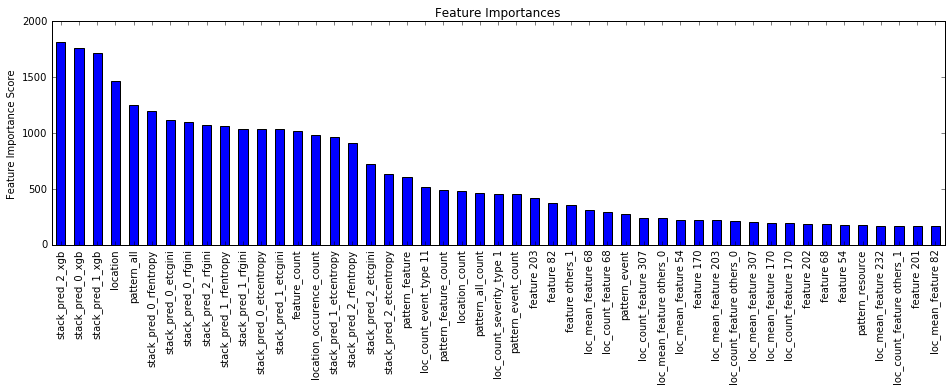


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4436   253   95
1                388  1411   72
2                 37    24  665
Note: rows - actual; col - predicted
Train (Accuracy) : 88.227%
Train (log_loss) : 0.316545
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 390, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 4100, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


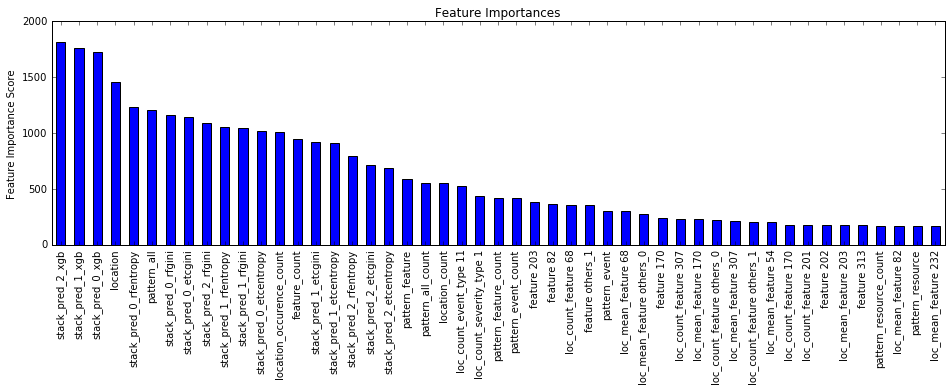


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4434   254   96
1                395  1400   76
2                 33    23  670
Note: rows - actual; col - predicted
Train (Accuracy) : 88.118%
Train (log_loss) : 0.317465
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 390, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 5100, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


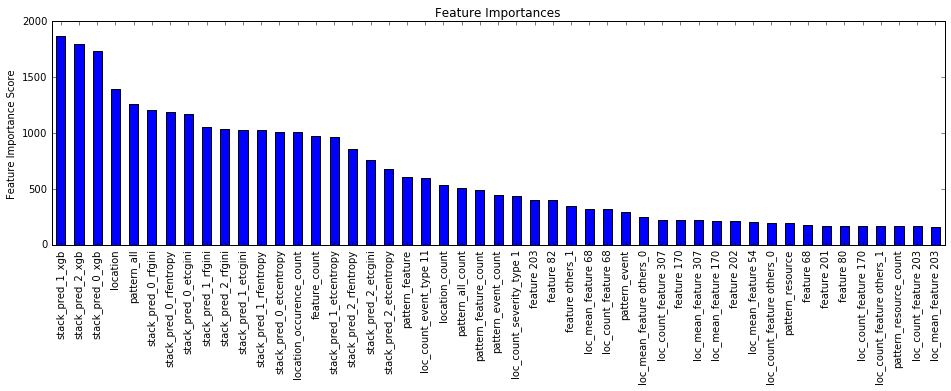


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4435   257   92
1                394  1407   70
2                 32    23  671
Note: rows - actual; col - predicted
Train (Accuracy) : 88.240%
Train (log_loss) : 0.315699
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 390, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 6100, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


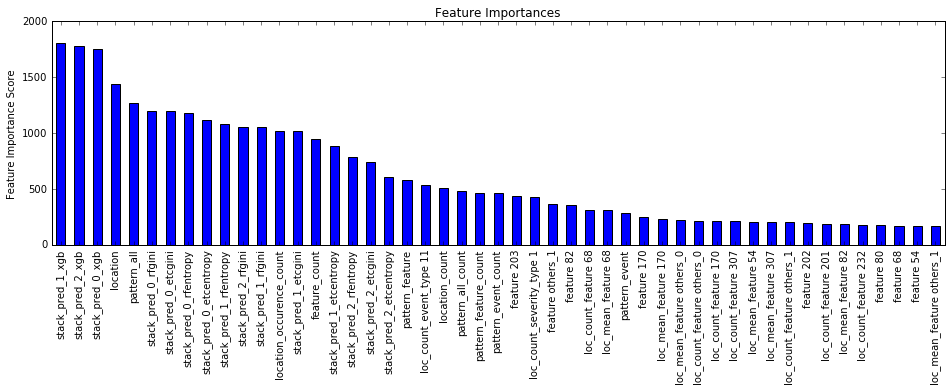


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4431   261   92
1                384  1417   70
2                 34    28  664
Note: rows - actual; col - predicted
Train (Accuracy) : 88.227%
Train (log_loss) : 0.315771
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 390, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 7100, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


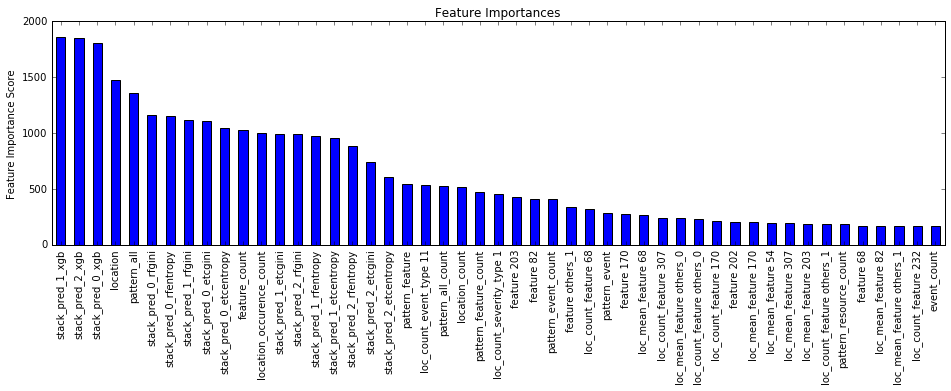


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4434   251   99
1                387  1416   68
2                 35    25  666
Note: rows - actual; col - predicted
Train (Accuracy) : 88.281%
Train (log_loss) : 0.315381
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 390, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 8100, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


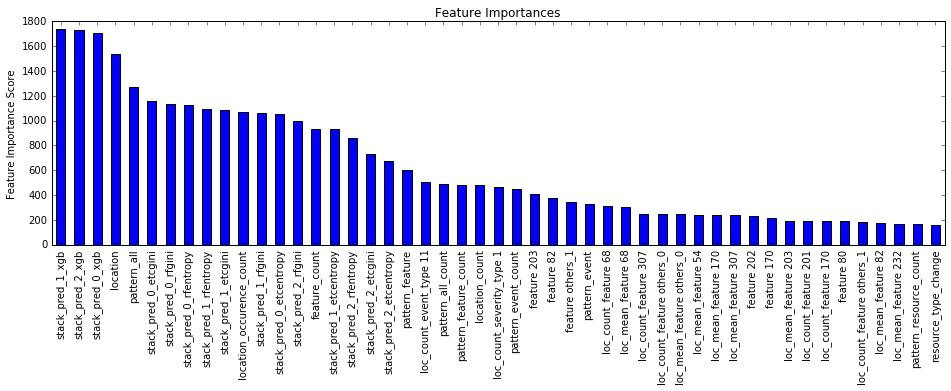


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4437   248   99
1                385  1413   73
2                 35    22  669
Note: rows - actual; col - predicted
Train (Accuracy) : 88.321%
Train (log_loss) : 0.315440
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0, 'colsample_bytree': 0.55, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 390, 'subsample': 0.85, 'reg_lambda': 1, 'seed': 9100, 'min_child_weight': 1, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.05}


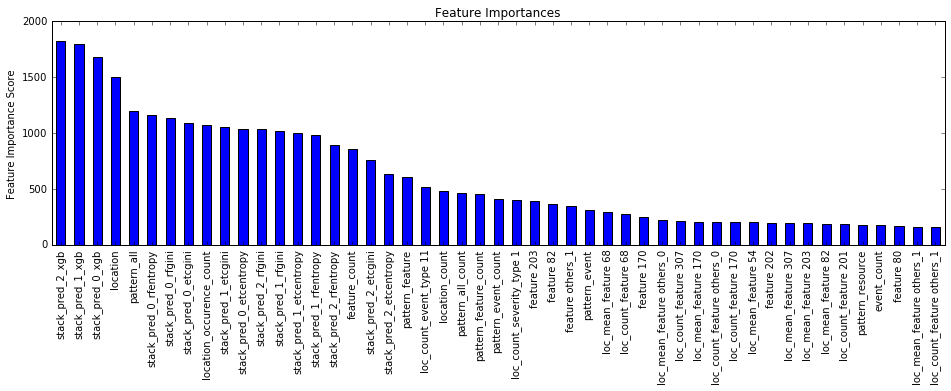


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4427   257  100
1                395  1404   72
2                 33    27  666
Note: rows - actual; col - predicted
Train (Accuracy) : 88.023%
Train (log_loss) : 0.318494
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000


In [57]:
for s in range(100,10000,1000):
    xgb15 = models_classification.XGBoost_Class(train2, test2, target, predictors, cv_folds=5, 
                                               scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
    xgb15.set_parameters({
            'learning_rate':0.02,
    'n_estimators':390,
    'max_depth':6,
    'min_child_weight':1,
    'gamma':0.05,
    'subsample':0.85,
    'colsample_bytree':0.55,
    'objective': 'multi:softprob',
    'num_class':3,
    'eval_metric':['mlogloss'],
    'missing':-1,
    'nthread':4,
    'scale_pos_weight':1,
            'seed':s
        })
    xgb15.modelfit(useTrainCV=False,performCV=False,show_progress=False,printTopN=50,early_stopping_rounds=100)
    fn = 'submissions/xgb15_mod10_seed%d.csv'%s
    xgb15.submission_proba(IDcol=[IDcol], proba_colnames=output_colnames, filename=fn)

In [58]:
model_comb = ['submissions/xgb15_mod10_seed%d.csv'%s for s in range(100,10000,1000)]
combine_models_multi(model_comb, 'submissions/xgb15_mod11_seedcombo.csv')
#Score: 0.49960

True


## Try regularization with xgboost (Try tonight):

In [114]:
predictors = [x for x in train2.columns if x not in [target, 'location2',IDcol]]
predictors = [x for x in predictors if not x.startswith('occurence')]

xgb16 = models_classification.XGBoost_Class(train2, test2, target, predictors, cv_folds=5, 
                                           scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
xgb16.set_parameters({
        'learning_rate':0.02,
    'n_estimators':447,
    'max_depth':6,
    'min_child_weight':2,
    'gamma':0.1,
    'subsample':0.9,
    'colsample_bytree':0.5,
    'objective': 'multi:softprob',
    'num_class':3,
    'eval_metric':['mlogloss'],
    'missing':-1,
    'nthread':4,
    'scale_pos_weight':1,
        'seed':27
    })
param_test1 = {
    'reg_alpha':[1e-10, 1e-5, 0.1, 1, 100],
}
xgb16.GridSearch(param_test1,n_jobs=4,iid=False,cv=5)
# xgb16.modelfit(useTrainCV=True,performCV=False,show_progress=False,printTopN=50,early_stopping_rounds=100)

Grid Search Results:
      reg_alpha    meanCV     stdCV
0  1.000000e-10 -0.491411  0.008760
1  1.000000e-05 -0.491411  0.008760
2  1.000000e-01 -0.491169  0.008911
3  1.000000e+00 -0.492172  0.009363
4  1.000000e+02 -0.531634  0.005722

Best Parameters:  {'reg_alpha': 0.1}

Best Score:  -0.491168631391


In [115]:
predictors = [x for x in train2.columns if x not in [target, 'location2',IDcol]]
predictors = [x for x in predictors if not x.startswith('occurence')]

xgb17 = models_classification.XGBoost_Class(train2, test2, target, predictors, cv_folds=5, 
                                           scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
xgb17.set_parameters({
        'learning_rate':0.02,
    'n_estimators':447,
    'max_depth':6,
    'min_child_weight':2,
    'gamma':0.1,
    'subsample':0.9,
    'colsample_bytree':0.5,
    'objective': 'multi:softprob',
    'num_class':3,
    'eval_metric':['mlogloss'],
    'missing':-1,
    'nthread':4,
    'scale_pos_weight':1,
        'seed':27
    })
param_test1 = {
    'reg_alpha':[0.001, 0.05, 0.1, 0.4],
}
xgb17.GridSearch(param_test1,n_jobs=4,iid=False,cv=5)

Grid Search Results:
   reg_alpha    meanCV     stdCV
0      0.001 -0.491202  0.008771
1      0.050 -0.491169  0.009021
2      0.100 -0.491169  0.008911
3      0.400 -0.491747  0.009110

Best Parameters:  {'reg_alpha': 0.05}

Best Score:  -0.491168598116


In [116]:
xgb18 = models_classification.XGBoost_Class(train2, test2, target, predictors, cv_folds=5, 
                                           scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
xgb18.set_parameters({
    'learning_rate':0.02,
    'n_estimators':447,
    'max_depth':6,
    'min_child_weight':2,
    'gamma':0.1,
    'subsample':0.9,
    'colsample_bytree':0.5,
    'objective': 'multi:softprob',
    'num_class':3,
    'eval_metric':['mlogloss'],
    'missing':-1,
    'nthread':4,
    'scale_pos_weight':1,
    'reg_alpha':0.05,
        'seed':27
    })
param_test1 = {
    'reg_lambda':[0, 1e-5, 0.1, 1],
}
xgb18.GridSearch(param_test1,n_jobs=4,iid=False,cv=5)

Grid Search Results:
   reg_lambda    meanCV     stdCV
0     0.00000 -0.491182  0.009117
1     0.00001 -0.491200  0.009117
2     0.10000 -0.491011  0.009300
3     1.00000 -0.491169  0.009021

Best Parameters:  {'reg_lambda': 0.1}

Best Score:  -0.491011194033


Will train until cv error hasn't decreased in 100 rounds.
Stopping. Best iteration:
[455] cv-mean:0.49274	cv-std:0.01751336975


{'reg_alpha': 0.05, 'colsample_bytree': 0.5, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 456, 'subsample': 0.9, 'reg_lambda': 0.1, 'seed': 27, 'min_child_weight': 2, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.1}


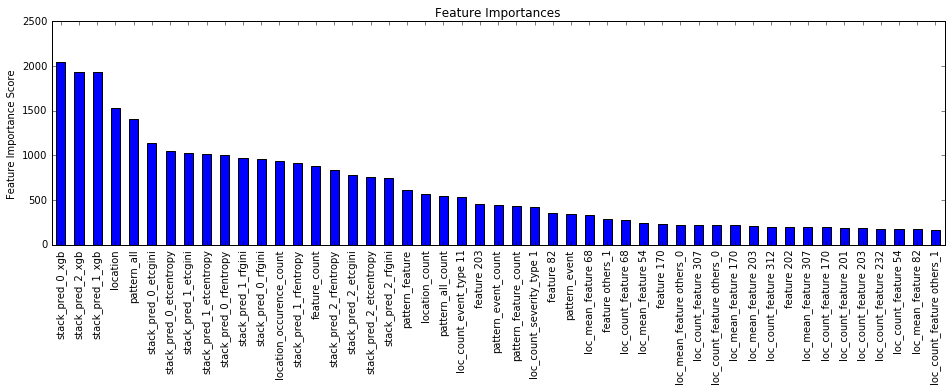


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4452   244   88
1                372  1438   61
2                 32    20  674
Note: rows - actual; col - predicted
Train (Accuracy) : 88.931%
Train (log_loss) : 0.309939
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000


In [118]:
xgb19 = models_classification.XGBoost_Class(train2, test2, target, predictors, cv_folds=5, 
                                           scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
xgb19.set_parameters({
    'learning_rate':0.02,
    'n_estimators':1000,
    'max_depth':6,
    'min_child_weight':2,
    'gamma':0.1,
    'subsample':0.9,
    'colsample_bytree':0.5,
    'objective': 'multi:softprob',
    'num_class':3,
    'eval_metric':['mlogloss'],
    'missing':-1,
    'nthread':4,
    'scale_pos_weight':1,
    'reg_alpha':0.05,
    'reg_lambda':0.1,
        'seed':27
    })
xgb19.modelfit(useTrainCV=True,performCV=False,show_progress=False,printTopN=50,early_stopping_rounds=100)

In [119]:
xgb19.submission_proba(IDcol=[IDcol], proba_colnames=output_colnames, filename='submissions/xgb19_mod10.csv')
#Score: 0.50137

{'reg_alpha': 0.05, 'colsample_bytree': 0.5, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 455, 'subsample': 0.9, 'reg_lambda': 0.1, 'seed': 88, 'min_child_weight': 2, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.1}


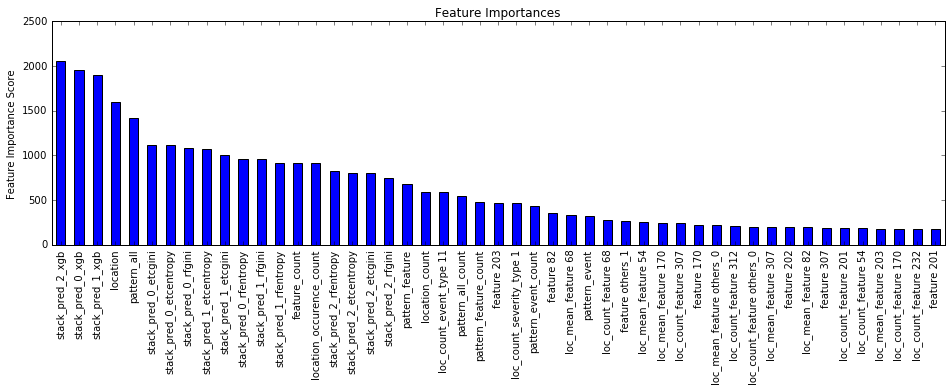


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4462   238   84
1                366  1442   63
2                 27    23  676
Note: rows - actual; col - predicted
Train (Accuracy) : 89.148%
Train (log_loss) : 0.308145
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0.05, 'colsample_bytree': 0.5, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 455, 'subsample': 0.9, 'reg_lambda': 0.1, 'seed': 1088, 'min_child_weight': 2, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.1}


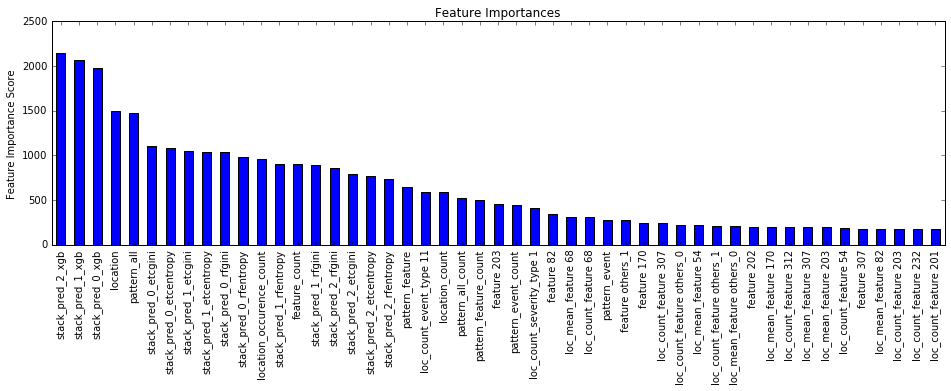


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4473   236   75
1                370  1440   61
2                 31    22  673
Note: rows - actual; col - predicted
Train (Accuracy) : 89.229%
Train (log_loss) : 0.307681
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0.05, 'colsample_bytree': 0.5, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 455, 'subsample': 0.9, 'reg_lambda': 0.1, 'seed': 2088, 'min_child_weight': 2, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.1}


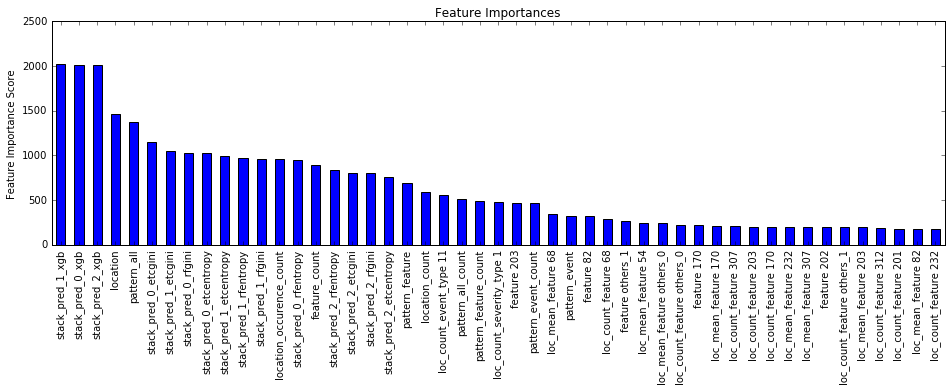


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4469   237   78
1                363  1447   61
2                 30    17  679
Note: rows - actual; col - predicted
Train (Accuracy) : 89.351%
Train (log_loss) : 0.307834
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0.05, 'colsample_bytree': 0.5, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 455, 'subsample': 0.9, 'reg_lambda': 0.1, 'seed': 3088, 'min_child_weight': 2, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.1}


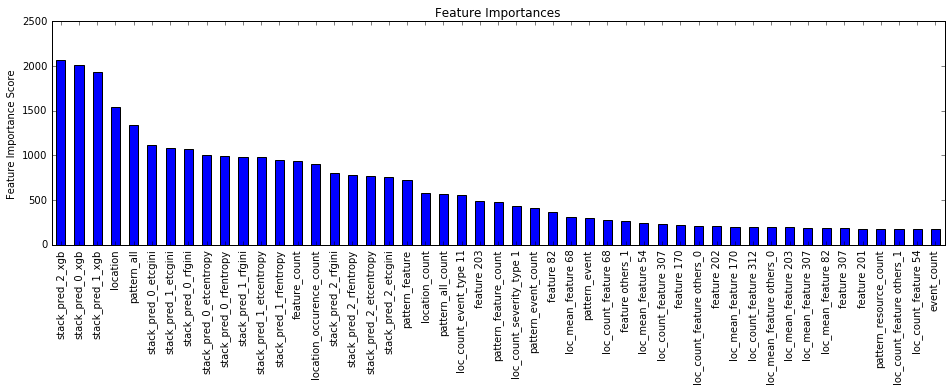


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4458   245   81
1                361  1447   63
2                 30    21  675
Note: rows - actual; col - predicted
Train (Accuracy) : 89.148%
Train (log_loss) : 0.308102
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0.05, 'colsample_bytree': 0.5, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 455, 'subsample': 0.9, 'reg_lambda': 0.1, 'seed': 4088, 'min_child_weight': 2, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.1}


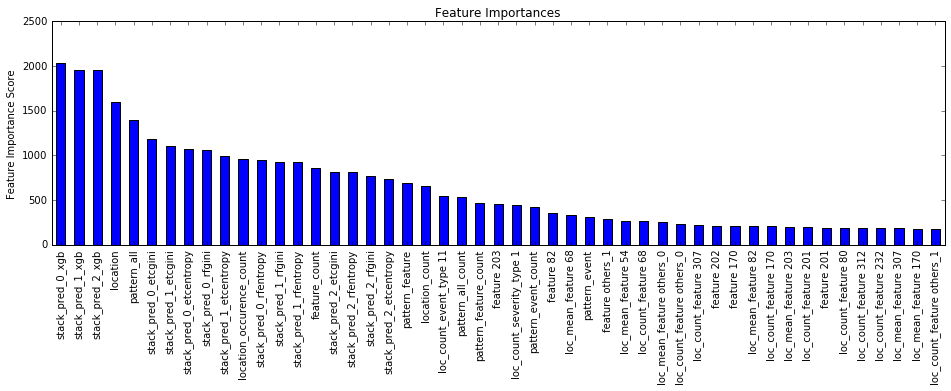


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4467   231   86
1                360  1451   60
2                 30    21  675
Note: rows - actual; col - predicted
Train (Accuracy) : 89.324%
Train (log_loss) : 0.307258
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0.05, 'colsample_bytree': 0.5, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 455, 'subsample': 0.9, 'reg_lambda': 0.1, 'seed': 5088, 'min_child_weight': 2, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.1}


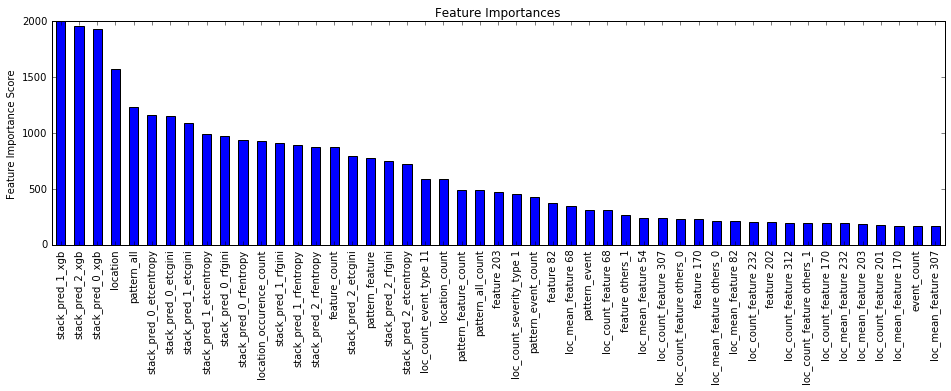


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4454   242   88
1                368  1440   63
2                 32    20  674
Note: rows - actual; col - predicted
Train (Accuracy) : 88.985%
Train (log_loss) : 0.308962
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0.05, 'colsample_bytree': 0.5, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 455, 'subsample': 0.9, 'reg_lambda': 0.1, 'seed': 6088, 'min_child_weight': 2, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.1}


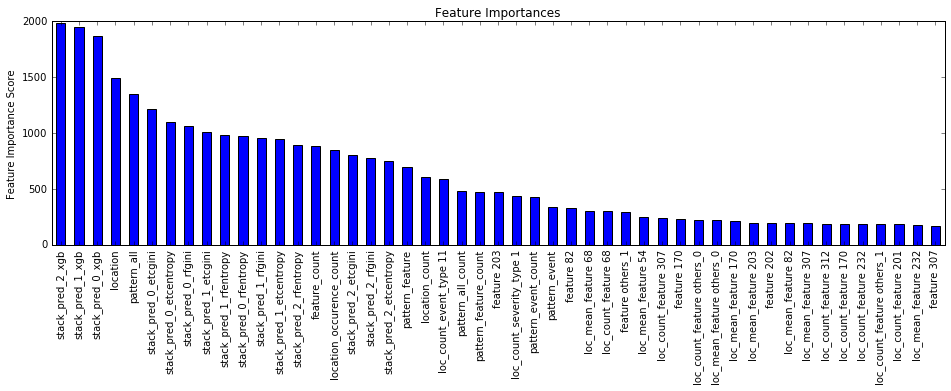


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4466   234   84
1                369  1442   60
2                 30    21  675
Note: rows - actual; col - predicted
Train (Accuracy) : 89.188%
Train (log_loss) : 0.308267
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0.05, 'colsample_bytree': 0.5, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 455, 'subsample': 0.9, 'reg_lambda': 0.1, 'seed': 7088, 'min_child_weight': 2, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.1}


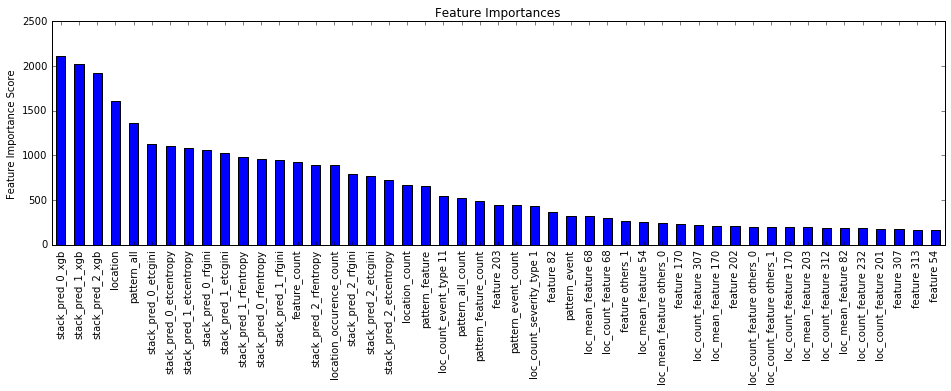


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4471   226   87
1                365  1445   61
2                 29    20  677
Note: rows - actual; col - predicted
Train (Accuracy) : 89.324%
Train (log_loss) : 0.307149
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0.05, 'colsample_bytree': 0.5, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 455, 'subsample': 0.9, 'reg_lambda': 0.1, 'seed': 8088, 'min_child_weight': 2, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.1}


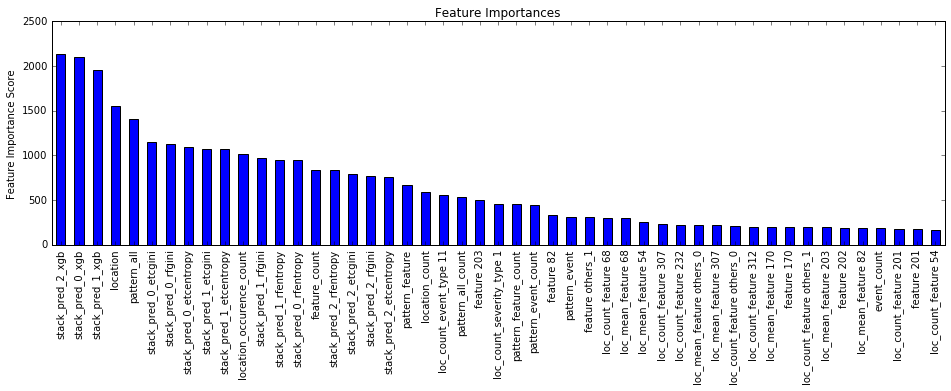


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4462   240   82
1                357  1452   62
2                 30    21  675
Note: rows - actual; col - predicted
Train (Accuracy) : 89.270%
Train (log_loss) : 0.306323
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000
{'reg_alpha': 0.05, 'colsample_bytree': 0.5, 'silent': True, 'colsample_bylevel': 1, 'scale_pos_weight': 1, 'learning_rate': 0.02, 'missing': -1, 'max_delta_step': 0, 'nthread': 4, 'base_score': 0.5, 'n_estimators': 455, 'subsample': 0.9, 'reg_lambda': 0.1, 'seed': 9088, 'min_child_weight': 2, 'objective': 'multi:softprob', 'max_depth': 6, 'gamma': 0.1}


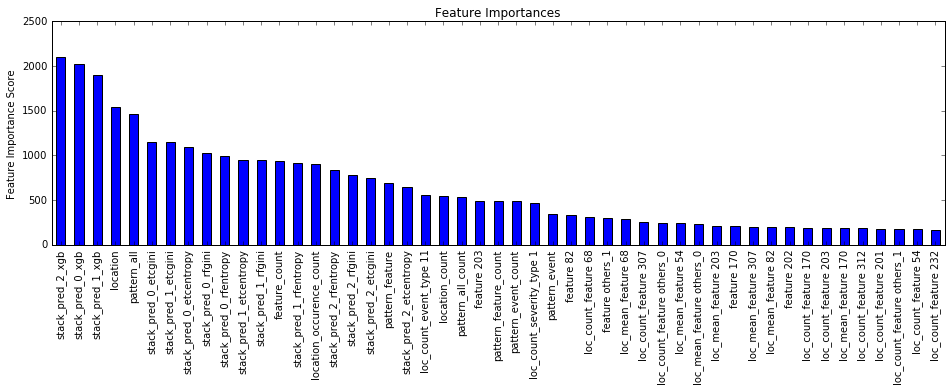


Model Report
Confusion Matrix:
col_0              0     1    2
fault_severity                 
0               4467   235   82
1                365  1445   61
2                 31    21  674
Note: rows - actual; col - predicted
Train (Accuracy) : 89.229%
Train (log_loss) : 0.307174
AUC : nan%
CV Score (Specified Metric) : Mean - 0.000000 | Std - 0.000000


In [122]:
for s in range(88,10000,1000):
    xgb20 = models_classification.XGBoost_Class(train2, test2, target, predictors, cv_folds=5, 
                                               scoring_metric_skl='log_loss', scoring_metric_xgb='mlogloss')
    xgb20.set_parameters({
            'learning_rate':0.02,
    'n_estimators':455,
    'max_depth':6,
    'min_child_weight':2,
    'gamma':0.1,
    'subsample':0.9,
    'colsample_bytree':0.5,
    'objective': 'multi:softprob',
    'num_class':3,
    'eval_metric':['mlogloss'],
    'missing':-1,
    'nthread':4,
    'scale_pos_weight':1,
            'reg_alpha':0.05,
    'reg_lambda':0.1,
            'seed':s
        })
    xgb20.modelfit(useTrainCV=False,performCV=False,show_progress=False,printTopN=50,early_stopping_rounds=100)
    fn = 'submissions/xgb20_mod10_seed%d.csv'%s
    xgb20.submission_proba(IDcol=[IDcol], proba_colnames=output_colnames, filename=fn)

In [124]:
model_comb = ['submissions/xgb20_mod10_seed%d.csv'%s for s in range(88,10000,1000)]
combine_models_multi(model_comb, 'data/submission_final.csv')
#Score: 

True


## EXport train-2 and test